In [1]:
import os
os.chdir('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/graph_var')

from graph_var.utils import load_graph_from_pkl, merge_dicts, log_action
from graph_var.graph import PangenomeGraph
from graph_var.evaluating_functions import *
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patches as mpatches
import math

version = 'v1'
ref_name = 'GRCh38'

graph_obj_dir = f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Graph_objs_{version}{'_chm13' if ref_name == 'CHM13' else ''}"
raw_vcf_dir = f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_chr"
graph_vcf_dir = f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_{version}{'_chm13' if ref_name == 'CHM13' else ''}"

ref_tree_dir = f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data/reference_tree_gfa_{version}{'_chm13' if ref_name == 'CHM13' else ''}"
gfa_dir = f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data/chromosome_gfa_{version}{'_chm13' if ref_name == 'CHM13' else ''}"
snarl_dir = f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data/chr_snarls_{version}{'_chm13' if ref_name == 'CHM13' else ''}"
bubble_summary_dir = f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Bubble_summary_{version}{'_chm13' if ref_name == 'CHM13' else ''}"

var_summary_dir = f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Stats_chr_{version}{'_chm13' if ref_name == 'CHM13' else ''}"
data_vis_dir = f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization_{version}{'_chm13' if ref_name == 'CHM13' else ''}"
chart_dir = f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts_{version}{'_chm13' if ref_name == 'CHM13' else ''}"

region_dir = f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Region_files"

mode = 'AT'
exclude_terminus = True

In [2]:
chr_set = 'autosome'

if chr_set == 'autosome':
    chr_list = list(range(1, 23))
elif chr_set == 'X':
    chr_list = ['X']
elif chr_set == 'Y':
    chr_list = ['Y']
else:
    raise ValueError("chr_set must be one of ['autosome', 'X', 'Y']")

num_chr = len(chr_list)

In [3]:
if not os.path.exists(f"{chart_dir}/subplots_{chr_set}/"):
    os.makedirs(f"{chart_dir}/subplots_{chr_set}")

In [4]:
assemble_dir = f"{chart_dir}/assembled_{chr_set}"
if not os.path.exists(assemble_dir):
    os.makedirs(assemble_dir)

In [5]:
import pandas as pd

file_path = f"{data_vis_dir}/supplementary_tables_{chr_set}.xlsx"

sheets = pd.read_excel(file_path, sheet_name=None)

In [6]:
graph_vcf_summary_concated_df = sheets['S1']
repeated_var_summary_concated_df = sheets['S2']

graph_vcf_summary_df = graph_vcf_summary_concated_df[graph_vcf_summary_concated_df['CHROM'] == 'all']
repeated_var_summary_df = repeated_var_summary_concated_df[repeated_var_summary_concated_df['CHROM'] == 'all']


In [31]:
region_concated_df = sheets['S4']
range_concated_df = sheets['S5']

region_df = region_concated_df[region_concated_df['CHROM'] == 'all']
range_df = range_concated_df[range_concated_df['CHROM'] == 'all']

Figure 2

In [32]:
fig1size = (14, 12)

title_fs = 14
barnum_fs = 12
legend_fs = 10
xtick_fs = 12
ytick_fs = 12
xlabel_fs = 14
ylabel_fs = 14
yoffset_fs = 14

panel_fs = 20

In [33]:
colors = {
    "primary": "#0343DF",
    "hatch": "black"
}

In [34]:
def plot_variant_summary_bar(ax, 
                             graph_vcf_summary_df, 
                             repeated_var_summary_df, 
                             colors,
                             colname, 
                             title="No title"):
    categories = ['SNPs', 'MNPs', 'Insertions', 'Deletions', 'Replacements', 'Duplications', 'Inversions']

    values = [
        int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == cat[:-1]][colname]) 
        for cat in categories
    ]

    repeat_values = [
        int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == cat[:-1]][colname]) 
        for cat in categories
    ]

    data = pd.DataFrame({
        'Category': categories,
        'Count': values,
        'Repeat Count': repeat_values
    })

    sns.set_theme(style="whitegrid", palette="muted", context="talk")

    bars = sns.barplot(y='Category', x='Count', data=data, ax=ax,
                       linewidth=1, edgecolor='black', color=colors['primary'], alpha=0.65)

    max_count = data['Count'].max()
    offset = 0.01 * max_count

    for i, (total_value, repeated_value) in enumerate(zip(data['Count'], data['Repeat Count'])):
        if repeated_value > 0:
            ax.barh(y=i, width=repeated_value, color="none",
                    edgecolor=colors["hatch"], hatch="///", linewidth=1)

    ax.set_title(title, fontsize=title_fs, weight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    ax.set_xticklabels([])
    ax.grid(False)

    sns.despine(ax=ax, left=False, bottom=False)

    for i, v in enumerate(data['Count']):
        ax.text(v + offset, i, f"{v}", va='center', fontsize=barnum_fs, color='black')

    # Add local legend directly to this subplot
    legend_patch = mpatches.Patch(facecolor="none", edgecolor="black", hatch="///",
                                   label="Tandem repeat\nor homopolymer")
    ax.legend(
        handles=[legend_patch],
        loc='lower right',
        fontsize=legend_fs
    )

def plot_stacked_bar_by_region(ax, region_df, comp_vcf='wave', title=None):
    # Extract counts from DataFrame
    shared_count_list = region_df[f"Shared_{comp_vcf}"].to_list()
    ourlinear_count_list = region_df[f"Ourvcf_linear_{comp_vcf}"].to_list()
    ourofflinear_count_list = region_df[f"Ourvcf_offlinear"].to_list()
    raw_count_list = region_df['Vcfwave_only' if comp_vcf == 'wave' else 'Rawvcf_only'].to_list()

    categories = ['Easy regions', 'Segdup regions', 'Difficult regions']
    x = np.arange(len(categories))

    fancy_colors = ["#0052C8", "#ff7f0e", "#2ca02c", "#d62728"]
    bar_width = 0.6
    alpha_value = 0.65
    lw = 0.5

    # Stack layers
    bottom1 = np.array(shared_count_list)
    bottom2 = bottom1 + np.array(ourlinear_count_list)
    bottom3 = bottom2 + np.array(ourofflinear_count_list)

    # Draw stacked bars on the provided ax
    ax.bar(x, shared_count_list, width=bar_width,
           label='Shared SNPs (GRCh38)', edgecolor='black', linewidth=lw,
           color=fancy_colors[0], alpha=alpha_value)

    ax.bar(x, ourlinear_count_list, width=bar_width, bottom=bottom1,
           label='pantree VCF SNPs (GRCh38)', edgecolor='black', linewidth=lw,
           color=fancy_colors[1], alpha=alpha_value)

    ax.bar(x, ourofflinear_count_list, width=bar_width, bottom=bottom2,
           label='pantree VCF SNPs (non-GRCh38)', edgecolor='black', linewidth=lw,
           color=fancy_colors[2], alpha=alpha_value)

    ax.bar(x, raw_count_list, width=bar_width, bottom=bottom3,
           label=f"{'vcfwave specific' if comp_vcf == 'wave' else 'Superbubble VCF'} SNPs (GRCh38)", edgecolor='black', linewidth=lw,
           color=fancy_colors[3], alpha=alpha_value)

    # Axis formatting
    ax.set_xticks(x)
    ax.set_xticklabels(categories, fontsize=xtick_fs)
    ax.tick_params(axis='y', labelsize=ylabel_fs)

    # Title
    if title is not None:
        ax.set_title(title, fontsize=title_fs, weight='bold')

    # Y-axis formatter
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    y_values = np.array(shared_count_list) + np.array(ourlinear_count_list) + np.array(ourofflinear_count_list) + np.array(raw_count_list)
    max_val = max(y_values)
    order = int(math.floor(math.log10(max_val)))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(order,order))
    ax.yaxis.offsetText.set_fontsize(yoffset_fs)

    # Legend
    ax.legend(fontsize=legend_fs, loc='best')

    # Clean up look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

    # Optional: Remove axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')

def plot_stacked_bar_by_ac_range(ax, range_df, comp_vcf='wave', title=None):
    # Extract counts from DataFrame
    simple_count_list = range_df[f"Shared_{comp_vcf}"].to_list()
    complex_count_list = range_df[f"Ourvcf_linear_{comp_vcf}"].to_list()
    nonlinear_count_list = range_df[f"Ourvcf_offlinear"].to_list()

    # Define minor allele count categories
    categories = ['Singleton', '2 - 4', '5 - 18', '19 +']
    x = np.arange(len(categories))

    fancy_colors = ["#0052C8", "#ff7f0e", "#2ca02c", "#d62728"]
    bar_width = 0.6
    alpha_value = 0.65
    lw = 0.5

    # Compute stack heights
    bottom1 = np.array(simple_count_list)
    bottom2 = bottom1 + np.array(complex_count_list)

    # Plot stacked bars
    ax.bar(x, simple_count_list, width=bar_width,
           label='Shared SNPs (GRCh38)', edgecolor='black', linewidth=lw,
           color=fancy_colors[0], alpha=alpha_value)

    ax.bar(x, complex_count_list, width=bar_width, bottom=bottom1,
           label='pantree VCF SNPs (GRCh38)', edgecolor='black', linewidth=lw,
           color=fancy_colors[1], alpha=alpha_value)

    ax.bar(x, nonlinear_count_list, width=bar_width, bottom=bottom2,
           label='pantree VCF SNPs (non-GRCh38)', edgecolor='black', linewidth=lw,
           color=fancy_colors[2], alpha=alpha_value)

    # Set axis and ticks
    ax.set_xticks(x)
    ax.set_xticklabels(categories, fontsize=xtick_fs)
    ax.tick_params(axis='y', labelsize=ylabel_fs)
    ax.set_xlabel('Minor allele count', fontsize=xlabel_fs)

    # Set title
    if title:
        ax.set_title(title, fontsize=title_fs, weight='bold')

    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    y_values = np.array(simple_count_list) + np.array(complex_count_list) + np.array(nonlinear_count_list)
    max_val = max(y_values)
    order = int(math.floor(math.log10(max_val)))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(order,order))
    ax.yaxis.offsetText.set_fontsize(yoffset_fs)

    # Legend
    ax.legend(fontsize=legend_fs, loc='best')

    # Clean look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

In [13]:
def save_subplot(plot_function, filename, w = 10, h = 8, *df):
    fig, axs = plt.subplots(1, 1, figsize=(w, h))
    # Use your custom plot function on each subplot
    plot_function(axs, *df)

    fig.tight_layout()

    fig.savefig(f"{filename}.pdf", format='pdf')
    fig.savefig(f"{filename}.svg", format='svg')
    fig.savefig(f"{filename}.png", bbox_inches="tight", dpi=600)

/tmp/ipykernel_36434/3537658783.py:10: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == cat[:-1]][colname])
/tmp/ipykernel_36434/3537658783.py:15: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == cat[:-1]][colname])
/tmp/ipykernel_36434/3537658783.py:10: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == cat[:-1]][colname])
/tmp/ipykernel_36434/3537658783.py:15: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(repeated_var_su

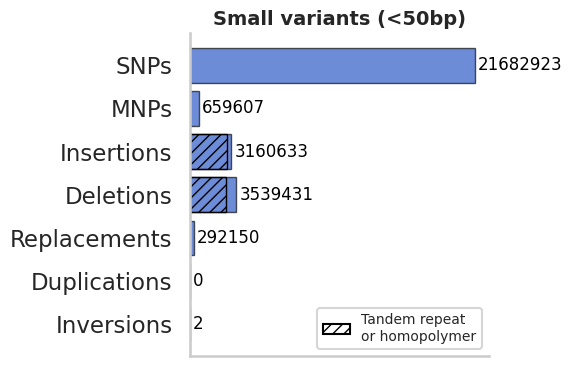

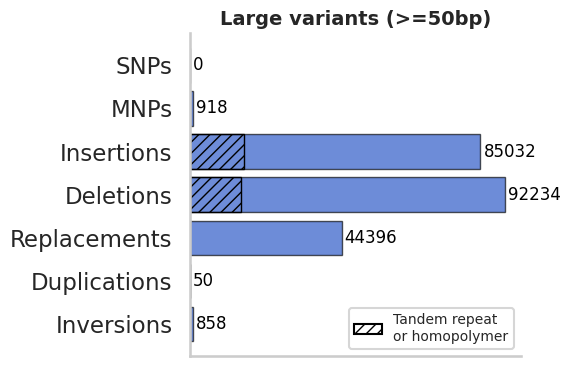

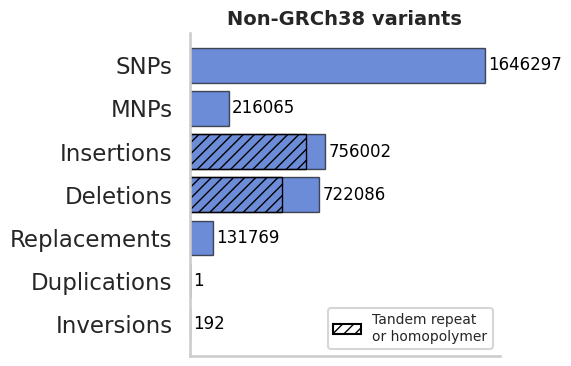

In [141]:
save_subplot(plot_variant_summary_bar,
             f"{chart_dir}/subplots_{chr_set}/figure2_1",
             6, 4,
             graph_vcf_summary_df, 
             repeated_var_summary_df, 
             colors, 
             "Small_Variants", 
             "Small variants (<50bp)")
save_subplot(plot_variant_summary_bar, 
             f"{chart_dir}/subplots_{chr_set}/figure2_2",
             6, 4,
             graph_vcf_summary_df, 
             repeated_var_summary_df, 
             colors, 
             "Large_Variants", 
             "Large variants (>=50bp)")
save_subplot(plot_variant_summary_bar, 
             f"{chart_dir}/subplots_{chr_set}/figure2_3",
             6, 4,
             graph_vcf_summary_df, 
             repeated_var_summary_df, 
             colors, 
             "Off_Linear_Variants", 
             "Non-GRCh38 variants")

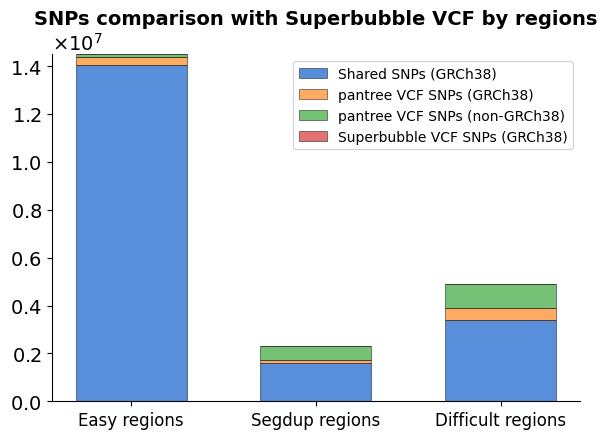

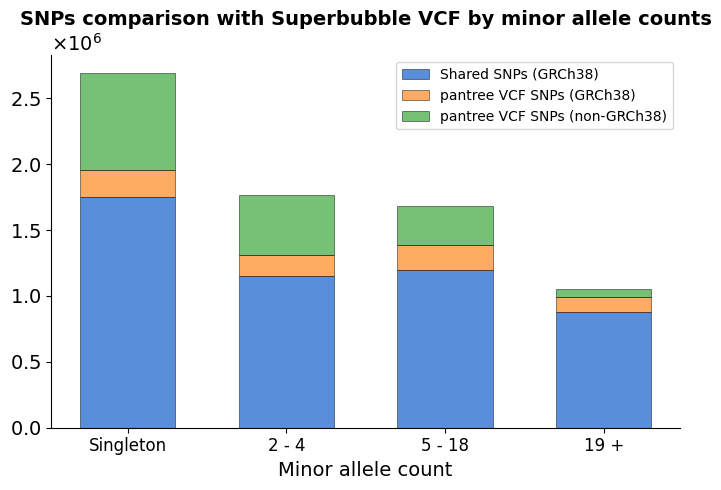

In [14]:
save_subplot(plot_stacked_bar_by_region, 
             f"{chart_dir}/subplots_{chr_set}/figure2_4",
             6, 4.5,
             region_df,
             "raw",
             "SNPs comparison with Superbubble VCF by regions")
save_subplot(plot_stacked_bar_by_ac_range, 
             f"{chart_dir}/subplots_{chr_set}/figure2_5",
             7, 5,
             range_df,
             "raw",
             "SNPs comparison with Superbubble VCF by minor allele counts")

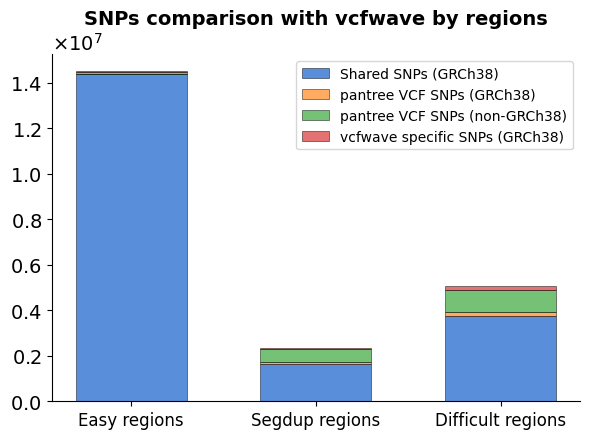

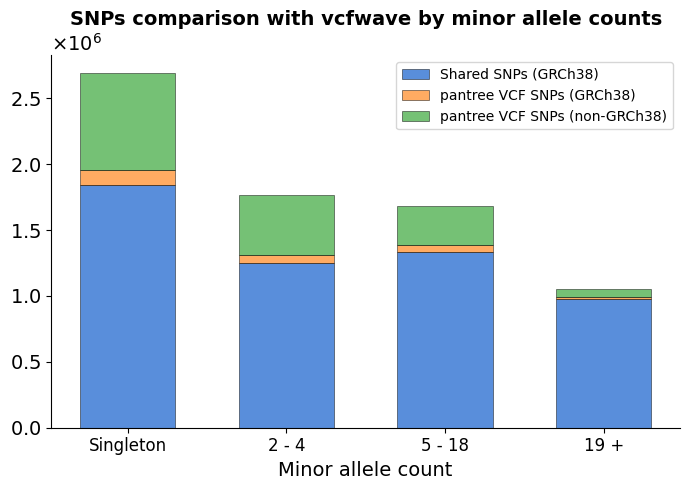

In [15]:
save_subplot(plot_stacked_bar_by_region, 
             f"{chart_dir}/subplots_{chr_set}/figure2_6",
             6, 4.5,
             region_df,
             "wave",
             "SNPs comparison with vcfwave by regions")
save_subplot(plot_stacked_bar_by_ac_range, 
             f"{chart_dir}/subplots_{chr_set}/figure2_7",
             7, 5,
             range_df,
             "wave",
             "SNPs comparison with vcfwave by minor allele counts")

Assemble Figure 2

/tmp/ipykernel_45222/1264175032.py:10: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == cat[:-1]][colname])
/tmp/ipykernel_45222/1264175032.py:15: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == cat[:-1]][colname])
/tmp/ipykernel_45222/1264175032.py:10: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == cat[:-1]][colname])
/tmp/ipykernel_45222/1264175032.py:15: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(repeated_var_su

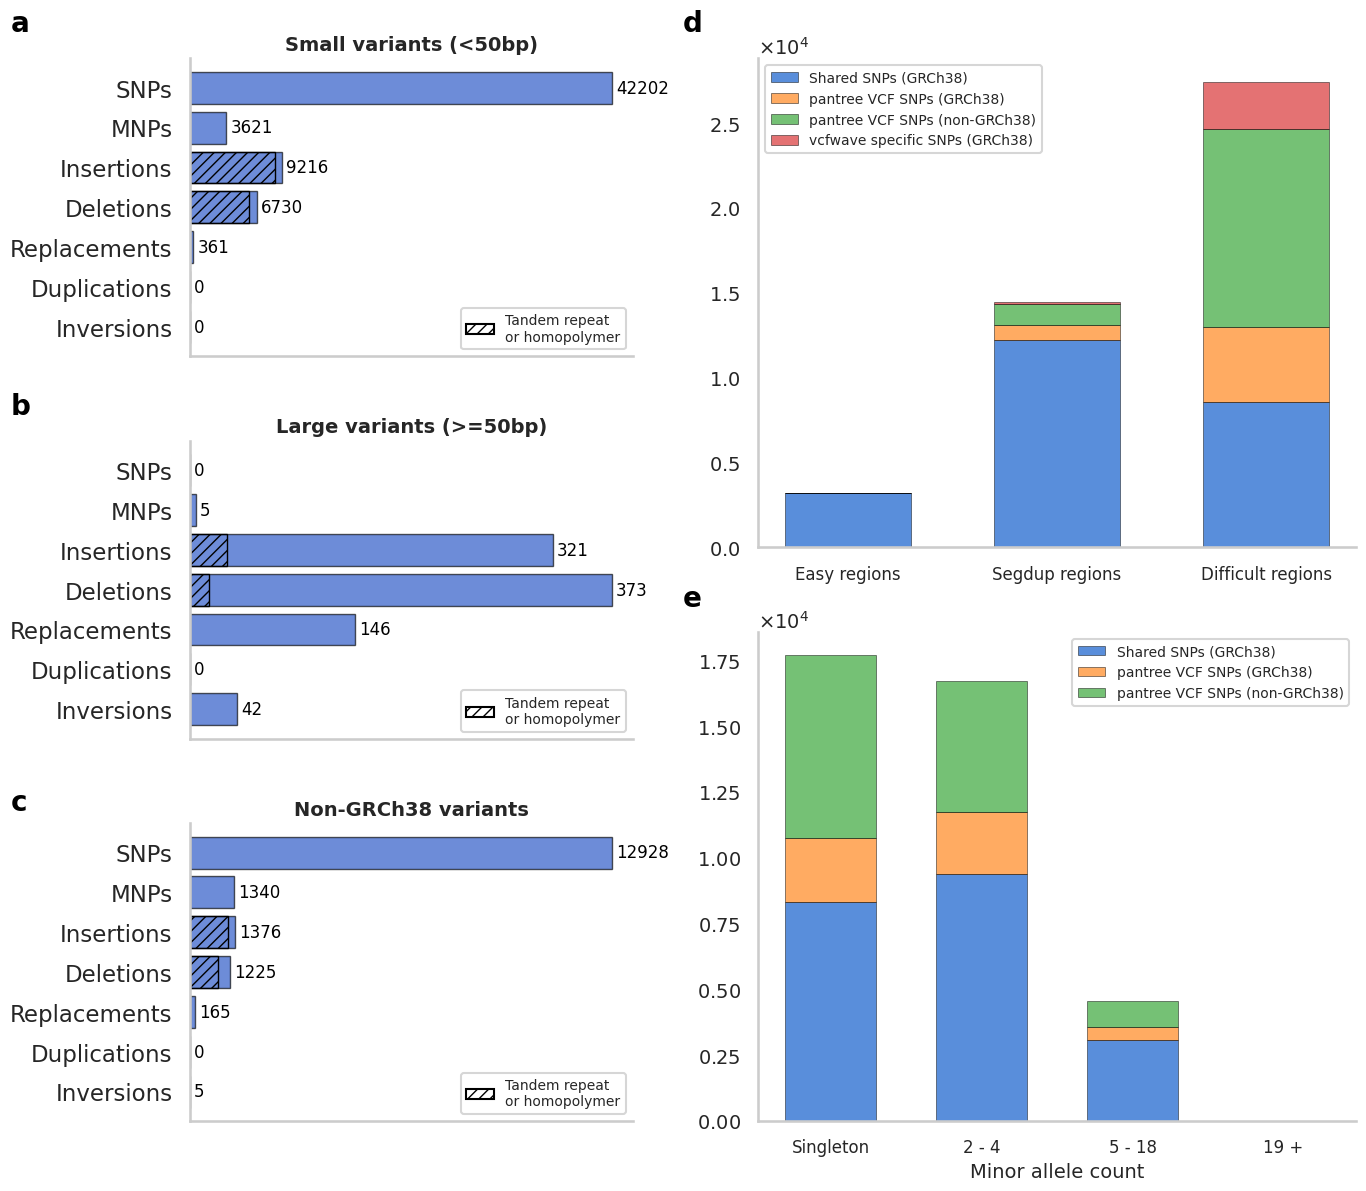

In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec


# Create figure and define a flexible grid layout
fig = plt.figure(figsize=fig1size)  # Define overall figure size
gs = gridspec.GridSpec(6, 2, width_ratios=[1, 1.35], height_ratios=[1, 1, 1, 1, 1, 1])  

# First three charts in the first column (one per row)
ax1 = fig.add_subplot(gs[0:2, 0])  # Row 1, Col 1
ax2 = fig.add_subplot(gs[2:4, 0])  # Row 2, Col 1
ax3 = fig.add_subplot(gs[4:6, 0])  # Row 3, Col 1

# Make Chart 4 and Chart 5 evenly share the second column
ax4 = fig.add_subplot(gs[0:3, 1])  # Chart 4 takes Row 1
ax5 = fig.add_subplot(gs[3:6, 1])  # Chart 5 takes Row 2 & 3

# Display images
plot_variant_summary_bar(ax1, 
                         graph_vcf_summary_df, 
                         repeated_var_summary_df, 
                         colors,
                         "Small_Variants", 
                         title="Small variants (<50bp)")
plot_variant_summary_bar(ax2, 
                         graph_vcf_summary_df, 
                         repeated_var_summary_df, 
                         colors,
                         "Large_Variants", 
                         title="Large variants (>=50bp)")
plot_variant_summary_bar(ax3, 
                         graph_vcf_summary_df, 
                         repeated_var_summary_df, 
                         colors,
                         "Off_Linear_Variants", 
                         title="Non-GRCh38 variants")
plot_stacked_bar_by_region(ax4, 
                           region_df,
                           "wave",
                           None)
plot_stacked_bar_by_ac_range(ax5, 
                             range_df,
                             "wave",
                             None)

# Remove axis labels and ticks for a clean layout
# for ax in [ax1, ax2, ax3, ax4, ax5]:
#     ax.axis("off")

# Define label positions to match the adjusted layout
label_positions = [(0.02, 0.999),  # a (Top-left)
                   (0.50, 0.999),  # d (Top-right)
                   (0.02, 0.68),  # b (Middle-left)
                   (0.02, 0.35),  # c (Bottom-left)
                   (0.50, 0.52)]  # e (Middle-right)

labels = ["a", "d", "b", "c", "e"]

# Add global labels to the whole figure
for (x, y), label in zip(label_positions, labels):
    fig.text(x, y, label, fontsize=panel_fs, fontweight="bold", va="top", ha="left", color="black")

# Adjust layout and save the final figure
plt.tight_layout()
plt.savefig(f"{assemble_dir}/assembled_figure2.pdf", format='pdf')
plt.savefig(f"{assemble_dir}/assembled_figure2.svg", format='svg')
plt.savefig(f"{assemble_dir}/assembled_figure2.png", bbox_inches="tight", dpi=600)

# Show the final image
plt.show()


Figure 3

In [6]:
import pandas as pd

grouped_bar_df = pd.read_excel(f"{data_vis_dir}/supplementary_tables_{chr_set}.xlsx", 
                           sheet_name='S6')
scatter_df = pd.read_excel(f"{data_vis_dir}/supplementary_tables_{chr_set}.xlsx", 
                           sheet_name='S7')
bubble_type_df = pd.read_excel(f"{data_vis_dir}/supplementary_tables_{chr_set}.xlsx", 
                           sheet_name='S8')
superbubble_summary_df = pd.read_excel(f"{data_vis_dir}/supplementary_tables_{chr_set}.xlsx", 
                            sheet_name='S10')

Plot functions

In [7]:
fig2size = (20, 12)

title_fs = 18
barnum_fs = 16
legend_fs = 14
xtick_fs = 18
ytick_fs = 18
xlabel_fs = 18
ylabel_fs = 18
yoffset_fs = 18

panel_fs = 20

In [8]:
hatch_superbubble_with_tr = True
colors = {
    "var": "#4C72B0",
    "var_linear": "#4C72B0",
    "var_offlinear": "#D62728",
    "superbubble": "#d16200",
    "superbubble_1": "#d16200",
    "superbubble_2": "#d09e00",
    "superbubble_3": "#95d100",
    "primary": "#0343DF",
    "hatch": "black"
}

In [10]:
def plot_grouped_bar(ax, grouped_bar_df, title="Variant edges vs. ALT alleles per superbubble"):
    bin_labels = grouped_bar_df['Ranges']
    counts_edges = grouped_bar_df['Variant edges']
    counts_alt = grouped_bar_df['ALT alleles']

    # Create bar positions
    bar_positions = np.arange(len(counts_edges))
    bar_width = 0.4

    # Plot bars onto ax
    bars_edges = ax.bar(bar_positions - bar_width / 2, counts_edges, width=bar_width,
                        color=colors['superbubble_1'], edgecolor="black", label="Variant edges per superbubble")

    bars_alt = ax.bar(bar_positions + bar_width / 2, counts_alt, width=bar_width,
                      color=colors['superbubble_2'], edgecolor="black", label="ALT alleles per superbubble")

    # Axis formatting
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(bin_labels, fontsize=xtick_fs)
    ax.tick_params(axis='y', labelsize=ylabel_fs)
    ax.set_ylim(top=max(max(counts_edges), max(counts_alt)) * 1.1)

    # Set title
    if title:
        ax.set_title(title, fontsize=title_fs, weight='bold')

    # Clean y-axis
    ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=5))

    # Scientific notation formatter
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    y_values = list(counts_edges) + list(counts_alt)
    max_val = max(y_values)
    order = int(math.floor(math.log10(max_val)))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(order,order))
    ax.yaxis.offsetText.set_fontsize(yoffset_fs)
    # ax.set_yticks([])

    ax.set_ylabel("Superbubbles", fontsize=ylabel_fs)

    # Add text annotations
    # for bar in bars_edges:
    #     height = bar.get_height()
    #     if height > 0:
    #         ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01 * max(counts_edges),
    #                 f"{int(height)}", ha='center', fontsize=barnum_fs, color="black")

    # for bar in bars_alt:
    #     height = bar.get_height()
    #     if height > 0:
    #         ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01 * max(counts_alt),
    #                 f"{int(height)}", ha='center', fontsize=barnum_fs, color="black")

    # Legend
    ax.legend(loc="upper right", fontsize=legend_fs)

def plot_scatter(ax, scatter_df, title=None):
    unique_coords = [(scatter_df.iloc[i]['Variant edges'], scatter_df.iloc[i]['ALT alleles']) 
                     for i in range(len(scatter_df))]
    counts = scatter_df['Counts'].to_numpy()

    # Filter by range
    min_range = 0
    max_range = 100
    
    # counts = np.log10(counts)
    percentile = np.percentile(counts, 90)

    # Alpha mapping
    min_alpha = 0.15
    max_alpha = 1

    alphas = []
    for count in counts:
        if count >= percentile:
            alphas.append(1.0)
        else:
            scaled = (count - counts.min()) / (percentile - counts.min()) if percentile > counts.min() else 0
            alpha = min_alpha + (max_alpha - min_alpha) * scaled
            alphas.append(alpha)

    # Plot with alpha indicating density
    for (x_val, y_val), alpha in zip(unique_coords, alphas):
        ax.scatter(x_val, y_val, color="black", s=8, alpha=alpha, edgecolors='none')

    # Add reference line y = x
    ax.plot([min_range, max_range], [min_range, max_range], color="red",
            linestyle="--", linewidth=1, label="y = x")

    # Set limits and labels
    ax.set_xlim(min_range, 3.01 * max_range)
    ax.set_ylim(min_range, max_range)
    ax.set_xlabel("Variant edges", fontsize=xlabel_fs)
    ax.set_ylabel("ALT alleles", fontsize=ylabel_fs)
    ax.tick_params(axis='both', labelsize=xtick_fs)

    if title:
        ax.set_title(title, fontsize=title_fs, weight='bold')

    ax.legend(loc="upper left", fontsize=legend_fs)
    ax.grid(False)

def plot_triallelic_bubble_summary(ax, bubble_type_df, title="Superbubbles with two variants and three alleles"):
    # Custom x labels in display order
    x_labels = ["Properly triallelic", "Overlapping", "Nested", "Interlocking"]
    
    # Ensure proper category order
    custom_order = ["properly_triallelic", "overlapping", "nested", "interlocking"]
    bubble_type_df["Bubble_type"] = pd.Categorical(
        bubble_type_df["Bubble_type"], categories=custom_order, ordered=True
    )
    bubble_type_df = bubble_type_df.sort_values("Bubble_type")

    y_values = bubble_type_df["Count"].values

    # Plot bars
    ax.bar(x_labels, y_values, color=colors['superbubble'], edgecolor="black", width=0.5)

    # Titles and axis styling
    if title:
        ax.set_title(title, fontsize=title_fs, weight="bold")

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_ylim(top=max(y_values) * 1.1)
    ax.tick_params(axis='both', labelsize=xtick_fs)

    ax.set_xticklabels(x_labels, rotation=15)

    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=5))

    # Custom formatter
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    max_val = max(y_values)
    order = int(math.floor(math.log10(max_val)))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(order,order))
    ax.yaxis.offsetText.set_fontsize(yoffset_fs)
    # ax.set_yticks([])

    ax.set_ylabel("Triallelic superbubbles", fontsize=ylabel_fs)

    # Style cleanup
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(False)

    # Optional: annotate bar values
    # y_bias = 0.01 * max(y_values)
    # for i, count in enumerate(y_values):
    #     ax.text(i, count + y_bias, str(count), ha="center", fontsize=barnum_fs, color='black')

In [12]:
def plot_superbubble_summary(ax, superbubble_summary_df, title="Counts of multi-allelic superbubbles"):
    # Custom x labels in display order
    x_labels = ["Deletions", "Insertions", "Neither"]
    y_values = [superbubble_summary_df["Superbubble count"][(superbubble_summary_df['Superbubble type'] == 'deletion') &
                                                            (~superbubble_summary_df['Superbubble ALT allele group'].isin({'1', '2'}))].sum(),
                superbubble_summary_df["Superbubble count"][(superbubble_summary_df['Superbubble type'] == 'insertion') &
                                                            (~superbubble_summary_df['Superbubble ALT allele group'].isin({'1', '2'}))].sum(),
                superbubble_summary_df["Superbubble count"][(superbubble_summary_df['Superbubble type'] == 'neither') &
                                                            (~superbubble_summary_df['Superbubble ALT allele group'].isin({'1', '2'}))].sum(),
              ]

    # Plot bars
    ax.bar(x_labels, y_values, color=colors['superbubble'], edgecolor="black", width=0.5)

    # Titles and axis styling
    if title:
        ax.set_title(title, fontsize=title_fs, weight="bold")

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_ylim(top=max(y_values) * 1.1)
    ax.tick_params(axis='both', labelsize=xtick_fs)

    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=5))

    # Custom formatter
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    max_val = max(y_values)
    order = int(math.floor(math.log10(max_val)))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(order,order))
    ax.yaxis.offsetText.set_fontsize(yoffset_fs)
    # ax.set_yticks([])

    ax.set_ylabel("Multiallelic superbubbles", fontsize=ylabel_fs)

    # Style cleanup
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(False)

    # Optional: annotate bar values
    # y_bias = 0.01 * max(y_values)
    # for i, count in enumerate(y_values):
    #     ax.text(i, count + y_bias, str(count), ha="center", fontsize=barnum_fs, color='black')
    
    # ax.legend(
    #     loc='best',
    #     fontsize=legend_fs
    # )

def plot_grouped_bar_variant_in_superbubble(ax, superbubble_summary_df, title="Variant counts in multi-allelic superbubbles"):
    bin_labels = ["Deletions", "Insertions", "Neither"]
    del_index = superbubble_summary_df['Superbubble type'] == 'deletion'
    ins_index = superbubble_summary_df['Superbubble type'] == 'insertion'
    nei_index = superbubble_summary_df['Superbubble type'] == 'neither'
    counts_1 = [superbubble_summary_df["Variants count (GRCh38)"][del_index &
                                                            (~superbubble_summary_df['Superbubble ALT allele group'].isin({'1', '2'}))].sum(),
                superbubble_summary_df["Variants count (GRCh38)"][ins_index &
                                                            (~superbubble_summary_df['Superbubble ALT allele group'].isin({'1', '2'}))].sum(),
                superbubble_summary_df["Variants count (GRCh38)"][nei_index &
                                                            (~superbubble_summary_df['Superbubble ALT allele group'].isin({'1', '2'}))].sum()]
    counts_2 = [superbubble_summary_df["Variants count (Non-GRCh38)"][del_index &
                                                            (~superbubble_summary_df['Superbubble ALT allele group'].isin({'1', '2'}))].sum(),
                superbubble_summary_df["Variants count (Non-GRCh38)"][ins_index &
                                                            (~superbubble_summary_df['Superbubble ALT allele group'].isin({'1', '2'}))].sum(),
                superbubble_summary_df["Variants count (Non-GRCh38)"][nei_index &
                                                            (~superbubble_summary_df['Superbubble ALT allele group'].isin({'1', '2'}))].sum()]

    # Create bar positions
    bar_positions = np.arange(len(counts_1))
    bar_width = 0.4

    # Plot bars onto ax
    bars_ref = ax.bar(bar_positions - bar_width / 2, counts_1, width=bar_width,
                        color=colors['var_linear'], edgecolor="black", label="GRCh38")

    bars_non_ref = ax.bar(bar_positions + bar_width / 2, counts_2, width=bar_width,
                      color=colors['var_offlinear'], edgecolor="black", label="Non-GRCh38")

    # Axis formatting
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(bin_labels, fontsize=xlabel_fs)
    ax.tick_params(axis='y', labelsize=ytick_fs)
    ax.set_ylim(top=max(max(counts_1), max(counts_2)) * 1.1)

    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=5))

    # Set title
    if title:
        ax.set_title(title, fontsize=title_fs, weight='bold')

    # Clean y-axis
    ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

    # Scientific notation formatter
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    y_values = counts_1 + counts_2
    max_val = max(y_values)
    order = int(math.floor(math.log10(max_val)))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(order,order))
    ax.yaxis.offsetText.set_fontsize(yoffset_fs)
    # ax.set_yticks([])

    ax.set_ylabel("Variant edges", fontsize=ylabel_fs)

    # Add text annotations
    # for bar in bars_ref:
    #     height = bar.get_height()
    #     if height > 0:
    #         ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01 * max(counts_1),
    #                 f"{int(height)}", ha='center', fontsize=barnum_fs, color="black")

    # for bar in bars_non_ref:
    #     height = bar.get_height()
    #     if height > 0:
    #         ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01 * max(counts_2),
    #                 f"{int(height)}", ha='center', fontsize=barnum_fs, color="black")

    # Legend
    ax.legend(loc="best", fontsize=legend_fs)

def plot_ac_range_grouped_superbubble_count(ax, superbubble_summary_df, 
                                            title="Multi-allelic superbubble count by allele count range"):
    bin_labels = ["3-4", "5-6", "7-9", "10-12", "13-19", "20+"]
    del_index = superbubble_summary_df['Superbubble type'] == 'deletion'
    ins_index = superbubble_summary_df['Superbubble type'] == 'insertion'
    nei_index = superbubble_summary_df['Superbubble type'] == 'neither'

    counts_1 = [
        superbubble_summary_df["Superbubble count"][(superbubble_summary_df["Superbubble ALT allele group"] == ac_range) & del_index].sum()
        for ac_range in bin_labels
    ]
    counts_2 = [
        superbubble_summary_df["Superbubble count"][(superbubble_summary_df["Superbubble ALT allele group"] == ac_range) & ins_index].sum()
        for ac_range in bin_labels
    ]
    counts_3 = [
        superbubble_summary_df["Superbubble count"][(superbubble_summary_df["Superbubble ALT allele group"] == ac_range) & nei_index].sum()
        for ac_range in bin_labels
    ]

    # Create bar positions
    bar_positions = np.arange(len(counts_1))
    bar_width = 0.27

    # Plot bars onto ax
    bars_1 = ax.bar(bar_positions - bar_width, counts_1, width=bar_width,
                        color=colors['superbubble_1'], edgecolor="black", label="Deletion superbubbles")

    bars_2 = ax.bar(bar_positions, counts_2, width=bar_width,
                      color=colors['superbubble_2'], edgecolor="black", label="Insertion superbubbles")
    bars_3 = ax.bar(bar_positions + bar_width, counts_3, width=bar_width,
                      color=colors['superbubble_3'], edgecolor="black", label="Other superbubbles")

    # Axis formatting
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(bin_labels, fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylim(top=max(max(counts_1), max(counts_2), max(counts_3)) * 1.1)

    # Set title
    if title:
        ax.set_title(title, fontsize=16, weight='bold')

    # Clean y-axis
    ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

    # Scientific notation formatter
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    y_values = counts_1 + counts_2 + counts_3
    max_val = max(y_values)
    order = int(math.floor(math.log10(max_val)))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(order,order))
    ax.yaxis.offsetText.set_fontsize(yoffset_fs)

    ax.set_ylabel("Multiallelic superbubbles", fontsize=ylabel_fs)

    # Add text annotations
    # for bar in bars_1:
    #     height = bar.get_height()
    #     if height > 0:
    #         ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01 * max(counts_1),
    #                 f"{int(height)}", ha='center', fontsize=9, color="black")

    # for bar in bars_2:
    #     height = bar.get_height()
    #     if height > 0:
    #         ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01 * max(counts_2),
    #                 f"{int(height)}", ha='center', fontsize=9, color="black")

    # Legend
    ax.legend(loc="best", fontsize=legend_fs)

def plot_ac_range_grouped_variant_in_superbubble(ax, superbubble_summary_df, title="Non-GRCh38 variant counts in multi-allelic superbubbles"):
    bin_labels = ["2", "3-4", "5-6", "7-9", "10-12", "13-19", "20+"]
    del_index = superbubble_summary_df['Superbubble type'] == 'deletion'
    ins_index = superbubble_summary_df['Superbubble type'] == 'insertion'

    counts_1 = [
        superbubble_summary_df["Variants count (Non-GRCh38)"][(superbubble_summary_df["Superbubble ALT allele group"] == ac_range) & del_index].sum()
        for ac_range in bin_labels
    ]
    counts_2 = [
        superbubble_summary_df["Variants count (Non-GRCh38)"][(superbubble_summary_df["Superbubble ALT allele group"] == ac_range) & ins_index].sum()
        for ac_range in bin_labels
    ]

    # Create bar positions
    bar_positions = np.arange(len(counts_1))
    bar_width = 0.4

    # Plot bars onto ax
    bars_ref = ax.bar(bar_positions - bar_width / 2, counts_1, width=bar_width,
                        color=colors['var_linear'], edgecolor="black", label="Deletion superbubbles")

    bars_non_ref = ax.bar(bar_positions + bar_width / 2, counts_2, width=bar_width,
                      color=colors['var_offlinear'], edgecolor="black", label="Insertion superbubbles")

    # Axis formatting
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(bin_labels, fontsize=xlabel_fs)
    ax.tick_params(axis='y', labelsize=ytick_fs)
    ax.set_ylim(top=max(max(counts_1), max(counts_2)) * 1.1)

    # Set title
    if title:
        ax.set_title(title, fontsize=title_fs, weight='bold')

    # Clean y-axis
    ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=5))

    # Scientific notation formatter
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    y_values = counts_1 + counts_2
    max_val = max(y_values)
    order = int(math.floor(math.log10(max_val)))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(order,order))
    ax.yaxis.offsetText.set_fontsize(yoffset_fs)
    # ax.set_yticks([])

    ax.set_ylabel("Variant edges", fontsize=ylabel_fs)

    # Add text annotations
    # for bar in bars_ref:
    #     height = bar.get_height()
    #     if height > 0:
    #         ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01 * max(counts_1),
    #                 f"{int(height)}", ha='center', fontsize=barnum_fs, color="black")

    # for bar in bars_non_ref:
    #     height = bar.get_height()
    #     if height > 0:
    #         ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01 * max(counts_2),
    #                 f"{int(height)}", ha='center', fontsize=barnum_fs, color="black")

    # Legend
    ax.legend(loc="best", fontsize=legend_fs)

In [13]:
def plot_ac_range_hatched_variant_by_tr(ax, 
                                        superbubble_summary_df, 
                                        title="TR variants distribution by ALT allele count"):
    bin_labels = ["2", "3-4", "5-6", "7-9", "10-12", "13-19", "20+"]

    counts_1 = [
        (superbubble_summary_df["Variants count (TR)"][(superbubble_summary_df["Superbubble ALT allele group"] == ac_range)].sum() +
        superbubble_summary_df["Variants count (Non-TR)"][(superbubble_summary_df["Superbubble ALT allele group"] == ac_range)].sum())
        for ac_range in bin_labels
    ]
    counts_2 = [
        superbubble_summary_df["Variants count (TR)"][(superbubble_summary_df["Superbubble ALT allele group"] == ac_range)].sum()
        for ac_range in bin_labels
    ]

    # Create bar positions
    bar_positions = np.arange(len(counts_1))
    bar_width = 0.5

    # Plot bars onto ax
    ax.bar(bar_positions, counts_1, width=bar_width,
            color=colors['var'], edgecolor="black")
    if hatch_superbubble_with_tr:
        for i, count in enumerate(counts_2):
            if count > 0:
                ax.bar(x=i, height=count, color="none",
                        edgecolor=colors["hatch"], hatch="///", width=bar_width, linewidth=1)

    # Axis formatting
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(bin_labels, fontsize=xlabel_fs)
    ax.tick_params(axis='y', labelsize=ytick_fs)
    ax.set_ylim(top=max(max(counts_1), max(counts_2)) * 1.1)

    # Set title
    if title:
        ax.set_title(title, fontsize=title_fs, weight='bold')

    # Clean y-axis
    ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=5))

    # Scientific notation formatter
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    y_values = counts_1 + counts_2
    max_val = max(y_values)
    order = int(math.floor(math.log10(max_val)))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(order,order))
    ax.yaxis.offsetText.set_fontsize(yoffset_fs)

    ax.set_ylabel("Variant edges", fontsize=ylabel_fs)
    ax.set_xlabel("ALT alleles per superbubble", fontsize=ylabel_fs)

    # Legend
    if hatch_superbubble_with_tr:
        legend_patch = mpatches.Patch(facecolor="none", edgecolor="black", hatch="///",
                                    label="Tandem repeat\nor homopolymer")
        ax.legend(
            handles=[legend_patch],
            loc='best',
            fontsize=legend_fs
        )
    # ax.legend(loc="best", fontsize=legend_fs)

In [17]:
def plot_superbubble_summary_hatched(ax, superbubble_summary_df, title="Counts of multi-allelic superbubbles"):
    # Custom x labels in display order
    x_labels = ["Deletions", "Insertions"]
    y_values = [superbubble_summary_df["Superbubble count"][(superbubble_summary_df['Superbubble type'] == 'deletion') &
                            (~superbubble_summary_df['Superbubble ALT allele group'].isin({}))].sum(),
                superbubble_summary_df["Superbubble count"][(superbubble_summary_df['Superbubble type'] == 'insertion') &
                            (~superbubble_summary_df['Superbubble ALT allele group'].isin({}))].sum(),
                ]
    
    y_values_hatch = [superbubble_summary_df["Superbubble count"][(superbubble_summary_df['Superbubble type'] == 'deletion') &
                                                            (~superbubble_summary_df['Superbubble ALT allele group'].isin({'1'}))].sum(),
                superbubble_summary_df["Superbubble count"][(superbubble_summary_df['Superbubble type'] == 'insertion') &
                                                            (~superbubble_summary_df['Superbubble ALT allele group'].isin({'1'}))].sum(),
                ]

    print(y_values, y_values_hatch)

    # Plot bars
    bar_width = 0.5
    ax.bar(x_labels, y_values, color=colors['superbubble'], edgecolor="black", width=bar_width)
    for i, count in enumerate(y_values_hatch):
            if count > 0:
                ax.bar(x=i, height=count, color="none",
                        edgecolor=colors["hatch"], hatch="///", width=bar_width, linewidth=1)

    # Titles and axis styling
    if title:
        ax.set_title(title, fontsize=title_fs, weight="bold")

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_ylim(top=max(y_values) * 1.3)
    ax.tick_params(axis='both', labelsize=xtick_fs)

    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=5))

    # Custom formatter
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    max_val = max(y_values)
    order = int(math.floor(math.log10(max_val)))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(order,order))
    ax.yaxis.offsetText.set_fontsize(yoffset_fs)
    # ax.set_yticks([])

    ax.set_ylabel("Superbubbles", fontsize=ylabel_fs)

    # Style cleanup
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(False)

    legend_patch = mpatches.Patch(facecolor="none", edgecolor="black", hatch="///",
                                    label="Superbubbles with\n>=2 alternative alleles")
    ax.legend(
        handles=[legend_patch],
        loc='best',
        fontsize=legend_fs
    )

In [18]:
def save_subplot(plot_function, df, filename, w = 10, h = 8, title=None):
    fig, axs = plt.subplots(1, 1, figsize=(w, h))
    # Use your custom plot function on each subplot
    plot_function(axs, df, title=title)

    fig.tight_layout()

    # fig.savefig(f"{filename}.pdf", format='pdf')
    # fig.savefig(f"{filename}.svg", format='svg')
    # fig.savefig(f"{filename}.png", bbox_inches="tight", dpi=600)

[1767792, 1135061] [661196, 193553]


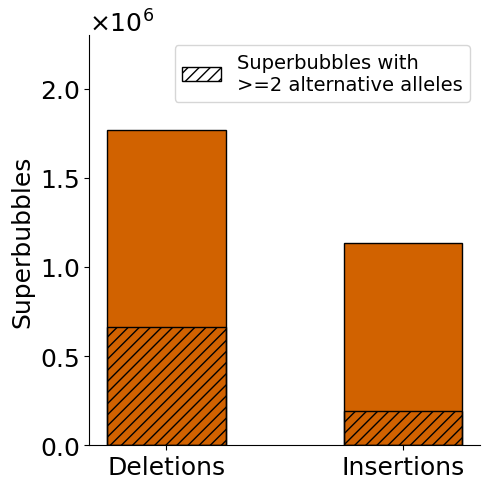

In [19]:
save_subplot(plot_superbubble_summary_hatched, 
             superbubble_summary_df, 
             f"{chart_dir}/subplots_{chr_set}/figure3_supp",
             w = 5, h = 5)

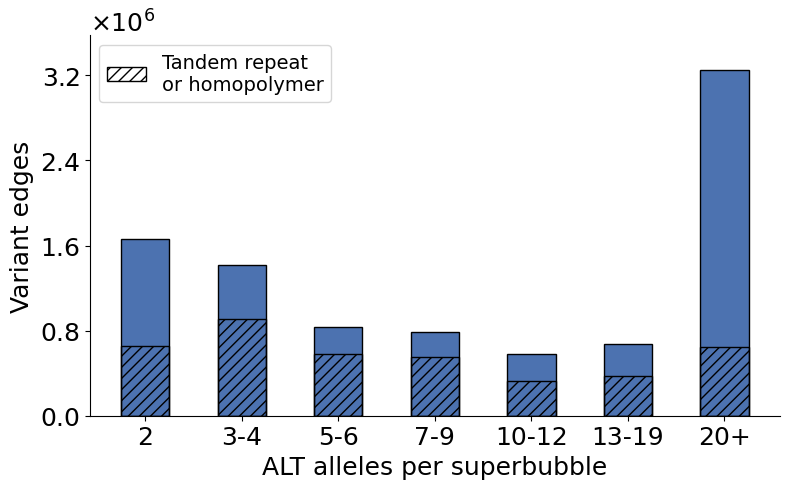

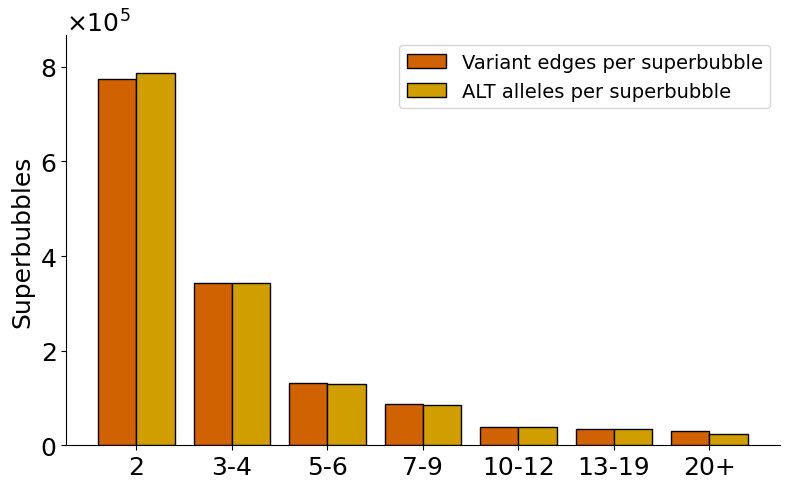

In [26]:
save_subplot(plot_ac_range_hatched_variant_by_tr, 
             superbubble_summary_df, 
             f"{chart_dir}/subplots_{chr_set}/figure3_1",
             w = 8, h = 5)
save_subplot(plot_grouped_bar, 
             grouped_bar_df, 
             f"{chart_dir}/subplots_{chr_set}/figure3_2",
             w = 8, h = 5)

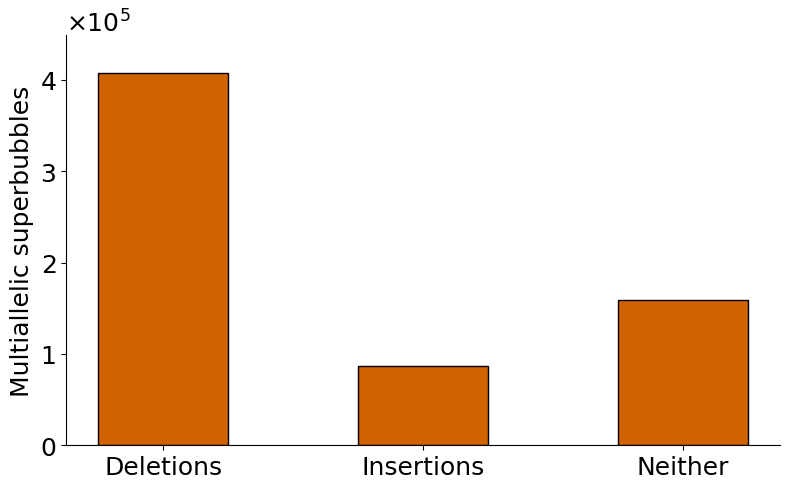

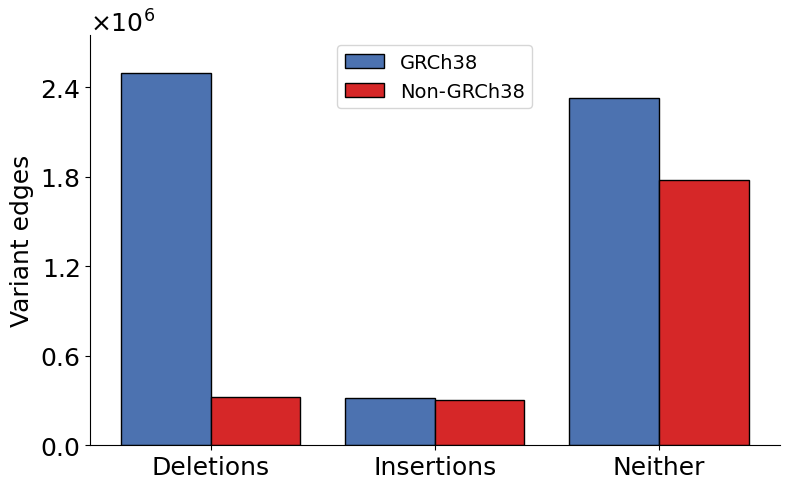

In [21]:
save_subplot(plot_superbubble_summary, 
             superbubble_summary_df, 
             f"{chart_dir}/subplots_{chr_set}/figure3_5",
             w = 8, h = 5)
save_subplot(plot_grouped_bar_variant_in_superbubble, 
             superbubble_summary_df, 
             f"{chart_dir}/subplots_{chr_set}/figure3_7",
             w = 8, h = 5)

/tmp/ipykernel_36434/1898347918.py:133: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=15)


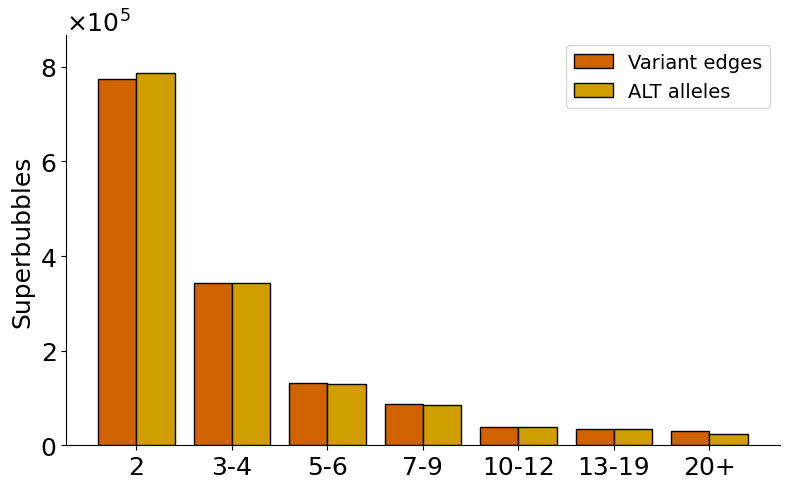

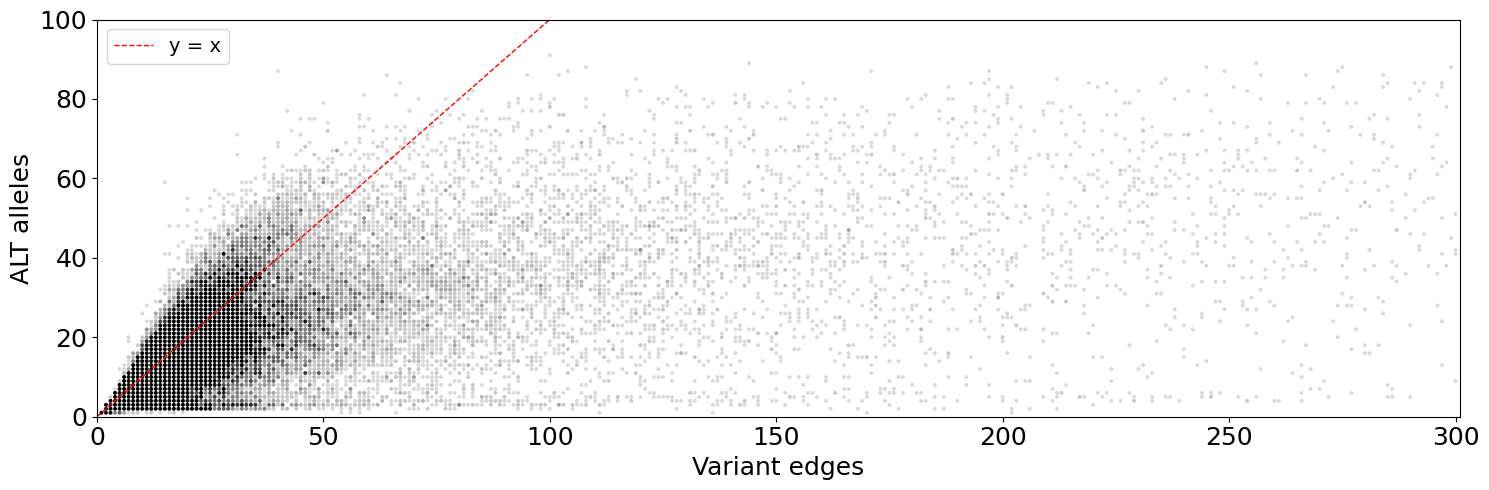

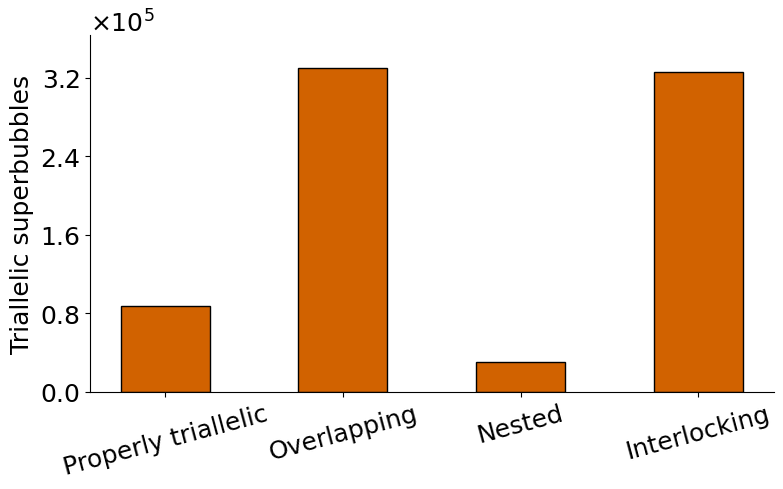

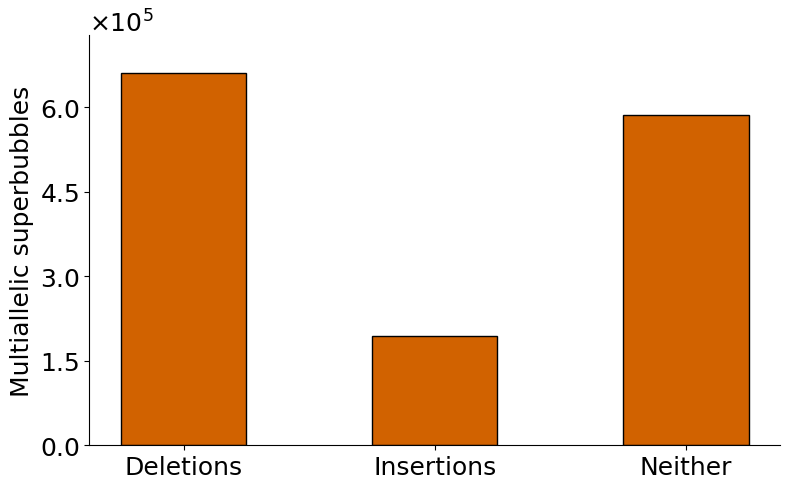

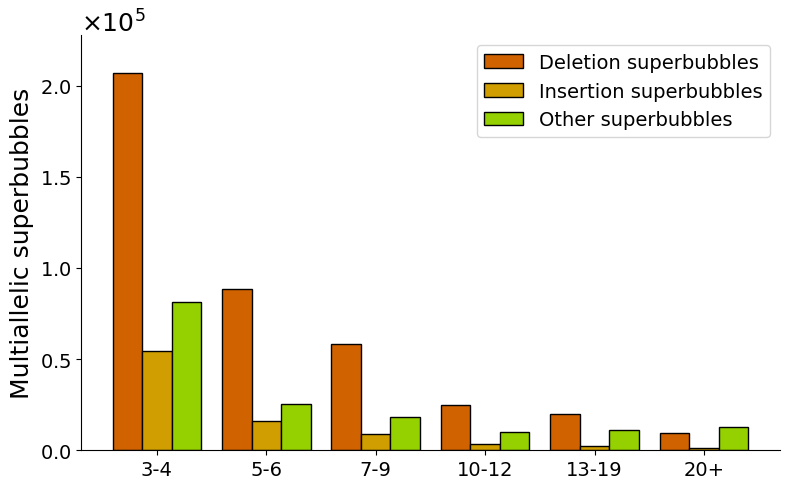

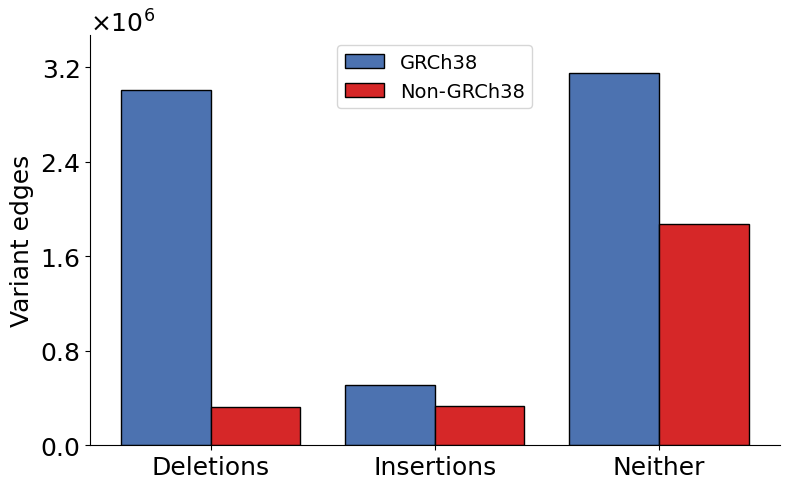

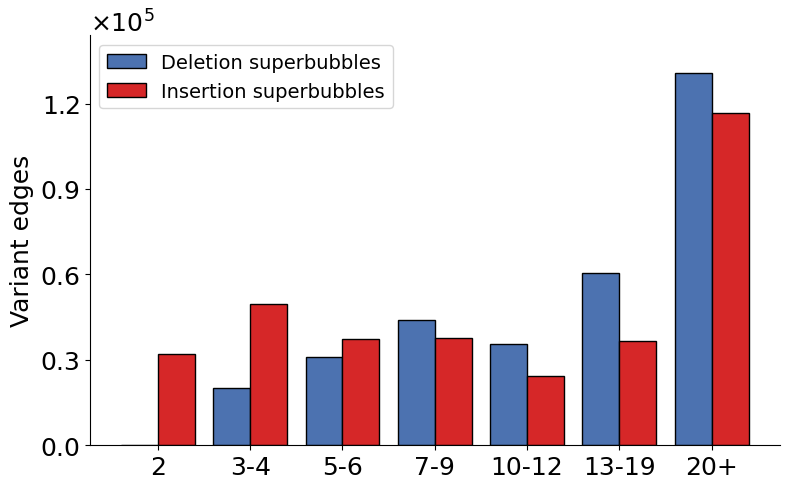

In [18]:
save_subplot(plot_scatter, 
             scatter_df, 
             f"{chart_dir}/subplots_{chr_set}/figure3_3", 
             w = 15, h = 5)
save_subplot(plot_triallelic_bubble_summary, 
             bubble_type_df, 
             f"{chart_dir}/subplots_{chr_set}/figure3_4",
             w = 8, h = 5)

save_subplot(plot_ac_range_grouped_superbubble_count,
             superbubble_summary_df,
             f"{chart_dir}/subplots_{chr_set}/figure3_6",
             w = 8, h = 5)
save_subplot(plot_ac_range_grouped_variant_in_superbubble, 
             superbubble_summary_df, 
             f"{chart_dir}/subplots_{chr_set}/figure3_8",
             w = 8, h = 5)


Assemble Figure 3

In [21]:
import cairosvg
from PIL import Image, ImageChops
import matplotlib.pyplot as plt
import io

def svg_to_png(svg_path, dpi=600):
    # Convert SVG to PNG at high resolution
    png_data = cairosvg.svg2png(url=svg_path, dpi=dpi)

    # Load PNG from bytes
    img = Image.open(io.BytesIO(png_data))

    return img

/tmp/ipykernel_15300/2354287598.py:133: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=15)


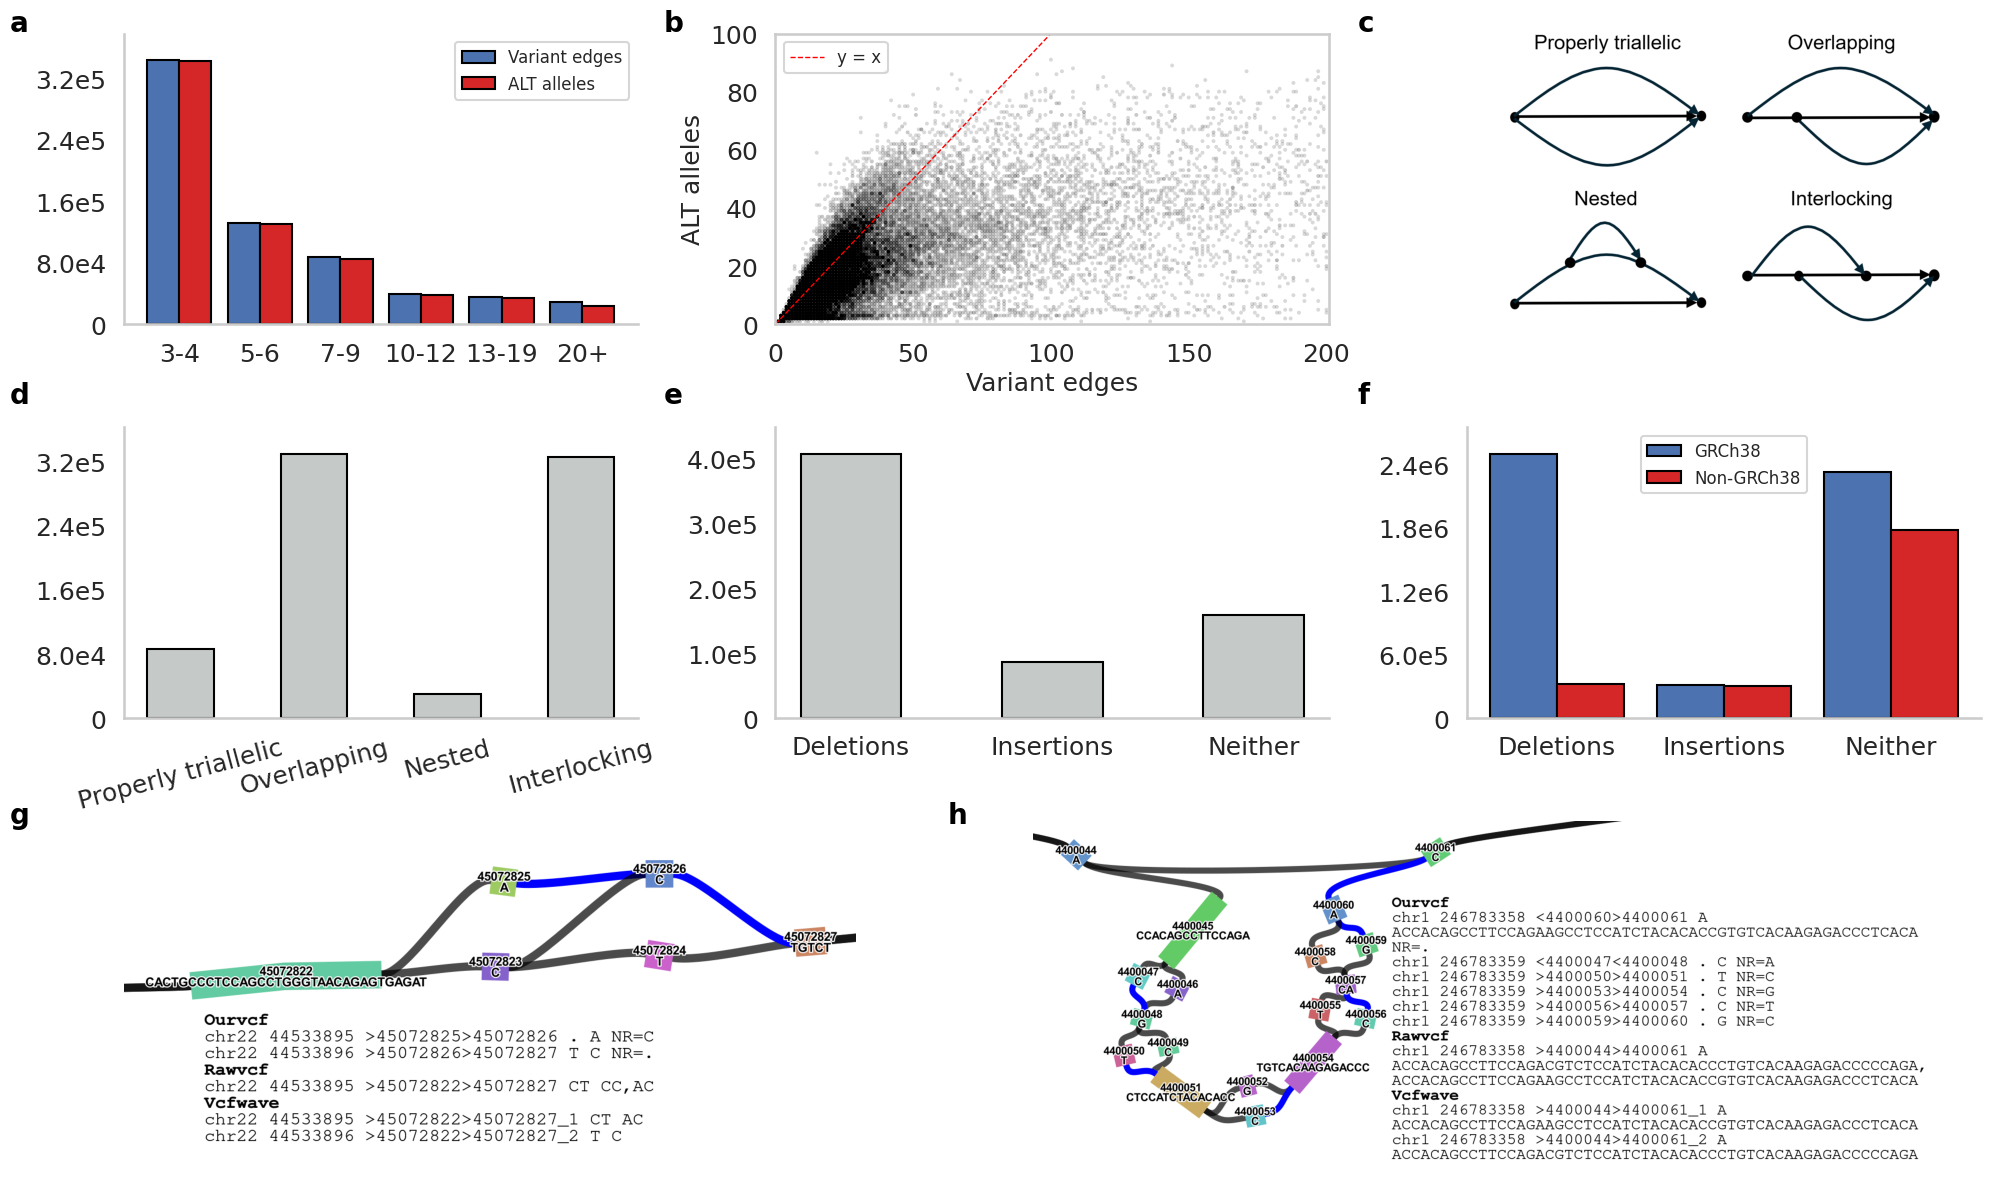

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

dpi = 1200

# Load images
img3 = mpimg.imread(f"{chart_dir}/schematic_triallelic.png")
img5 = svg_to_png(f"{chart_dir}/triallelic_example_annotated.svg", dpi=dpi)
img6 = svg_to_png(f"{chart_dir}/multiallelic_example_annotated.svg", dpi=dpi)

# Create figure and define a flexible grid layout
fig = plt.figure(figsize=fig2size)  # Define overall figure size
gs = gridspec.GridSpec(3, 9, width_ratios=[1, 1, 1, 1, 1.25, 1.25, 1, 1, 1], height_ratios=[1, 1, 1.2])  

# First three charts in the first column (one per row)
ax1 = fig.add_subplot(gs[0, 0:3])  # Row 1, Col 1
ax2 = fig.add_subplot(gs[0, 3:6])  # Row 2, Col 1
ax3 = fig.add_subplot(gs[0, 6:9])

# Make Chart 4 and Chart 5 evenly share the second column
ax4 = fig.add_subplot(gs[1, 0:3])  # Chart 4 takes Row 1
ax5 = fig.add_subplot(gs[2, 0:4])  # Chart 5 takes Row 2 & 3
ax6 = fig.add_subplot(gs[2, 4:9])

ax7 = fig.add_subplot(gs[1, 3:6])
ax8 = fig.add_subplot(gs[1, 6:9])

# Add plots
plot_grouped_bar(ax1, grouped_bar_df, title=None)
plot_scatter(ax2, scatter_df)
ax3.imshow(img3)
plot_triallelic_bubble_summary(ax4, bubble_type_df, title=None)
ax5.imshow(img5)
ax6.imshow(img6)
plot_superbubble_summary(ax7, superbubble_summary_df, title=None)
plot_grouped_bar_variant_in_superbubble(ax8, superbubble_summary_df, title=None)

# Remove axis labels and ticks for a clean layout
for ax in [ax3, ax5, ax6]:
    ax.axis("off")

ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xlabel("")
ax3.set_ylabel("")

ax5.set_xticks([])
ax5.set_yticks([])
ax5.set_xlabel("")
ax5.set_ylabel("")

ax6.set_xticks([])
ax6.set_yticks([])
ax6.set_xlabel("")
ax6.set_ylabel("")

# Define label positions to match the adjusted layout
label_positions = [(0.001, 0.99),
                   (0.328, 0.99),
                   (0.675, 0.99),
                   (0.001, 0.68),
                   (0.328, 0.68),
                   (0.675, 0.68),
                   (0.001, 0.33),
                   (0.470, 0.33),]

labels = ["a", "b", "c", "d", "e", "f", "g", "h"]

# Add global labels to the whole figure
for (x, y), label in zip(label_positions, labels):
    fig.text(x, y, label, fontsize=panel_fs, fontweight="bold", va="top", ha="left", color="black")

# Adjust layout and save the final figure
plt.tight_layout()
plt.savefig(f"{assemble_dir}/assembled_figure3.pdf", bbox_inches="tight", dpi=dpi)
plt.savefig(f"{assemble_dir}/assembled_figure3.png", bbox_inches="tight", dpi=dpi)

# Show the final image
plt.show()


Figure 4

In [46]:
from svgutils.compose import Figure, SVG, Text
from svgutils.transform import fromfile
from IPython.display import SVG as JupyterSVG, display
import pandas as pd

from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF
from reportlab.pdfgen import canvas
from reportlab.lib.units import cm

svg1_path = "/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Special_region/region_bandage/svg/HLA_simplified_gt_1000_single.svg"
svg2_path = "/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Special_region/region_bandage/svg/RHD_simplified_gt_1000_single.svg"


In [47]:
special_region_summary_df = pd.read_csv(f"{data_vis_dir}/special_region_var_summary.csv")


In [48]:
colors = {
    "primary": "#0343DF",
    "hatch": "black"
}

In [49]:
import cairosvg
from PIL import Image, ImageChops
import matplotlib.pyplot as plt
import io

def svg_to_png(svg_path, padding_ratio=0.05, dpi=600):
    # Convert SVG to PNG at high resolution
    png_data = cairosvg.svg2png(url=svg_path, dpi=dpi)

    # Load PNG from bytes
    img = Image.open(io.BytesIO(png_data)).convert("RGB")

    img_array = np.array(img)

    # Define white and mask
    white = np.array([255, 255, 255])
    non_white_mask = np.any(img_array != white, axis=2)

    # If all white, skip
    if not np.any(non_white_mask):
        print("Image is entirely white.")
        return img

    # Get bounding box coordinates
    rows = np.any(non_white_mask, axis=1)
    cols = np.any(non_white_mask, axis=0)
    top, bottom = np.argmax(rows), len(rows) - np.argmax(rows[::-1]) - 1
    left, right = np.argmax(cols), len(cols) - np.argmax(cols[::-1]) - 1

    # Compute padding
    height, width = img_array.shape[:2]
    pad_x = int(padding_ratio * (right - left + 1))
    pad_y = int(padding_ratio * (bottom - top + 1))

    # Apply padding and clamp to image boundaries
    left = max(left - pad_x, 0)
    right = min(right + pad_x, width - 1)
    top = max(top - pad_y, 0)
    bottom = min(bottom + pad_y, height - 1)

    # Crop and return
    cropped = img.crop((left, top, right + 1, bottom + 1))  # right/bottom are exclusive

    return cropped

def plot_region_var(ax,
                    special_region_name, 
                    special_region_summary_df,
                    colors,
                    title="No title"):
    categories = ['SNPs', 'MNPs', 'Insertions', 'Deletions', 'Replacements', 'Duplications', 'Inversions']

    region_row = special_region_summary_df[special_region_summary_df['Region'] == special_region_name].iloc[0]

    values = [
        region_row[category[:-1]] for category in categories
    ]


    data = pd.DataFrame({
        'Category': categories,
        'Count': values
    })

    sns.set_theme(style="whitegrid", palette="muted", context="talk")

    bars = sns.barplot(y='Category', x='Count', data=data, ax=ax,
                       linewidth=1, edgecolor='black', color=colors['primary'], alpha=0.65)

    max_count = data['Count'].max()
    offset = 0.01 * max_count

    # for i, (total_value, repeated_value) in enumerate(zip(data['Count'], data['Repeat Count'])):
    #     if repeated_value > 0:
    #         ax.barh(y=i, width=repeated_value, color="none",
    #                 edgecolor=colors["hatch"], hatch="///", linewidth=1)

    ax.set_title(title, fontsize=18, weight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    ax.set_xticklabels([])
    ax.grid(False)

    sns.despine(ax=ax, left=False, bottom=False)

    for i, v in enumerate(data['Count']):
        ax.text(v + offset, i, f"{v}", va='center', fontsize=12, color='black')

    # Add local legend directly to this subplot
    # legend_patch = mpatches.Patch(facecolor="none", edgecolor="black", hatch="///",
    #                                label="Tandem repeat\nor homopolymer")
    # ax.legend(
    #     handles=[legend_patch],
    #     loc='lower right',
    #     fontsize=12
    # )

In [27]:
import cairosvg
from PIL import Image, ImageChops
import matplotlib.pyplot as plt
import io

def svg_to_png(svg_path, padding_ratio=0.05, dpi=600):
    # Convert SVG to PNG at high resolution
    png_data = cairosvg.svg2png(url=svg_path, dpi=dpi)

    # Load PNG from bytes
    img = Image.open(io.BytesIO(png_data)).convert("RGB")

    img_array = np.array(img)

    # Define white and mask
    white = np.array([255, 255, 255])
    non_white_mask = np.any(img_array != white, axis=2)

    # If all white, skip
    if not np.any(non_white_mask):
        print("Image is entirely white.")
        return img

    # Get bounding box coordinates
    rows = np.any(non_white_mask, axis=1)
    cols = np.any(non_white_mask, axis=0)
    top, bottom = np.argmax(rows), len(rows) - np.argmax(rows[::-1]) - 1
    left, right = np.argmax(cols), len(cols) - np.argmax(cols[::-1]) - 1

    # Compute padding
    height, width = img_array.shape[:2]
    pad_x = int(padding_ratio * (right - left + 1))
    pad_y = int(padding_ratio * (bottom - top + 1))

    # Apply padding and clamp to image boundaries
    left = max(left - pad_x, 0)
    right = min(right + pad_x, width - 1)
    top = max(top - pad_y, 0)
    bottom = min(bottom + pad_y, height - 1)

    # Crop and return
    cropped = img.crop((left, top, right + 1, bottom + 1))  # right/bottom are exclusive

    return cropped

/home/shz311/.conda/envs/AIpy310/lib/python3.10/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (101965856 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


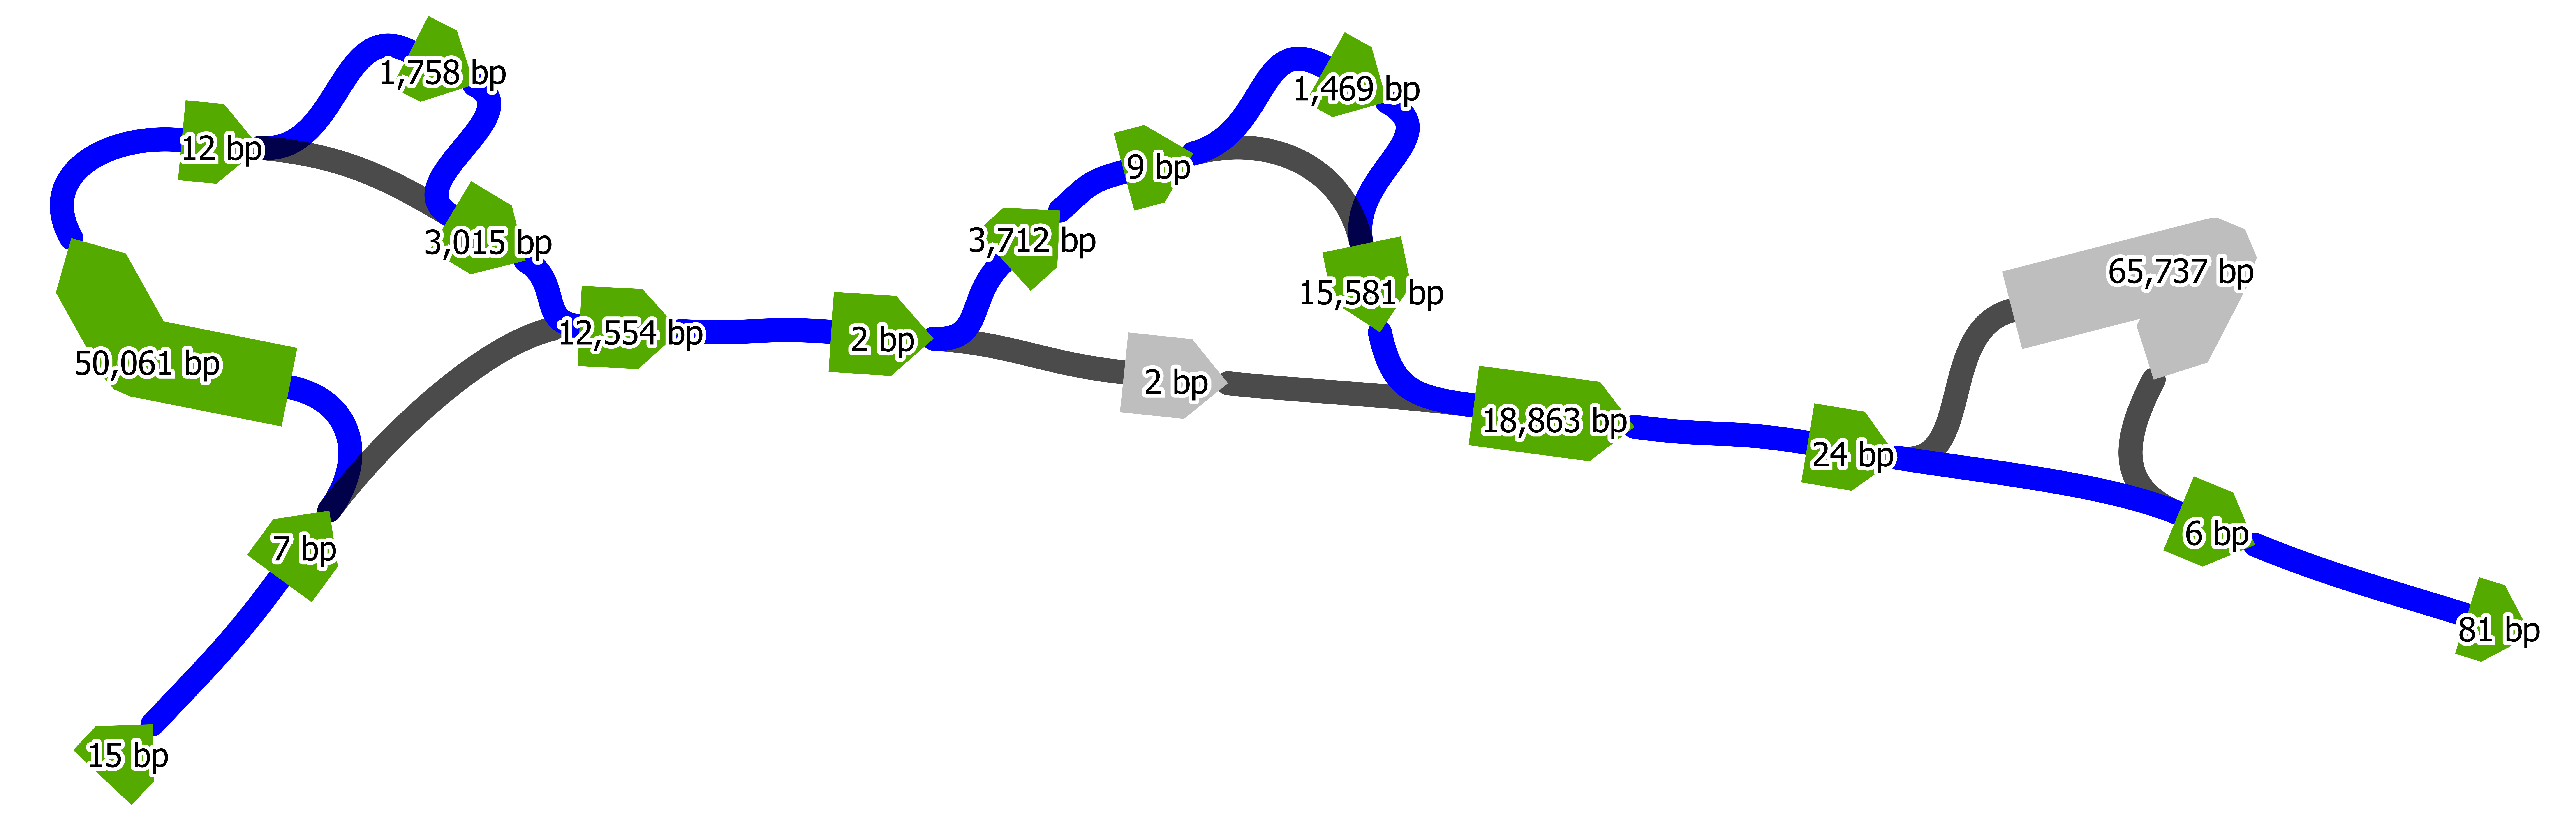

In [28]:
from IPython.display import display

svg1 = svg_to_png(svg1_path, padding_ratio=0.02, dpi=600)

display(svg1)

In [42]:
def save_subplot(plot_function, filename, w, h, *df):
    fig, axs = plt.subplots(1, 1, figsize=(w, h))
    # Use your custom plot function on each subplot
    plot_function(axs, *df)

    fig.tight_layout()

    fig.savefig(f"{filename}.pdf", format='pdf')
    fig.savefig(f"{filename}.svg", format='svg')
    fig.savefig(f"{filename}.png", bbox_inches="tight", dpi=600)

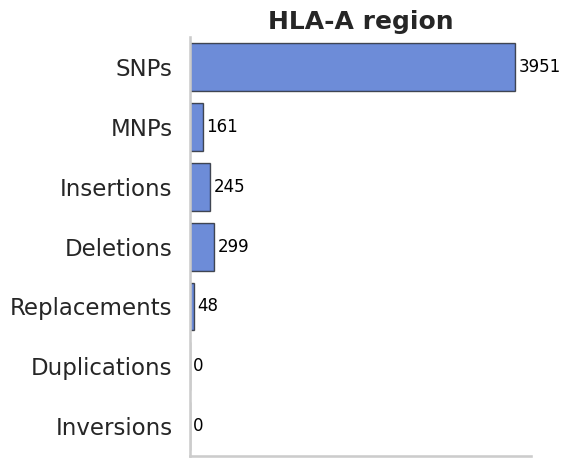

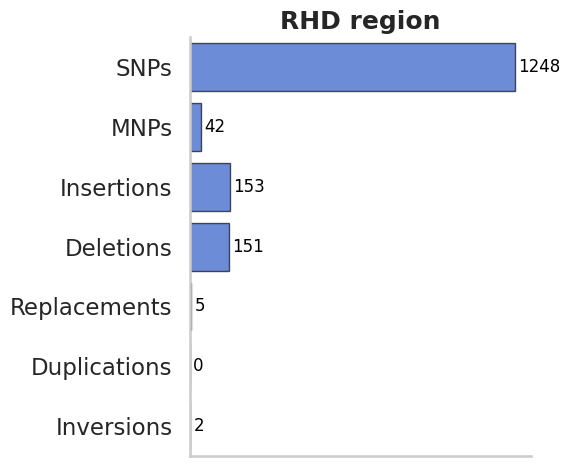

In [53]:
save_subplot(plot_region_var,
             f"{chart_dir}/subplots_{chr_set}/figure4_1",
             6, 5,
             "HLA", 
             special_region_summary_df, 
             colors,
             "HLA-A region")
save_subplot(plot_region_var,
             f"{chart_dir}/subplots_{chr_set}/figure4_2",
             6, 5,
             "RHD", 
             special_region_summary_df, 
             colors,
             "RHD region")

/home/shz311/.conda/envs/AIpy310/lib/python3.10/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (98429631 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


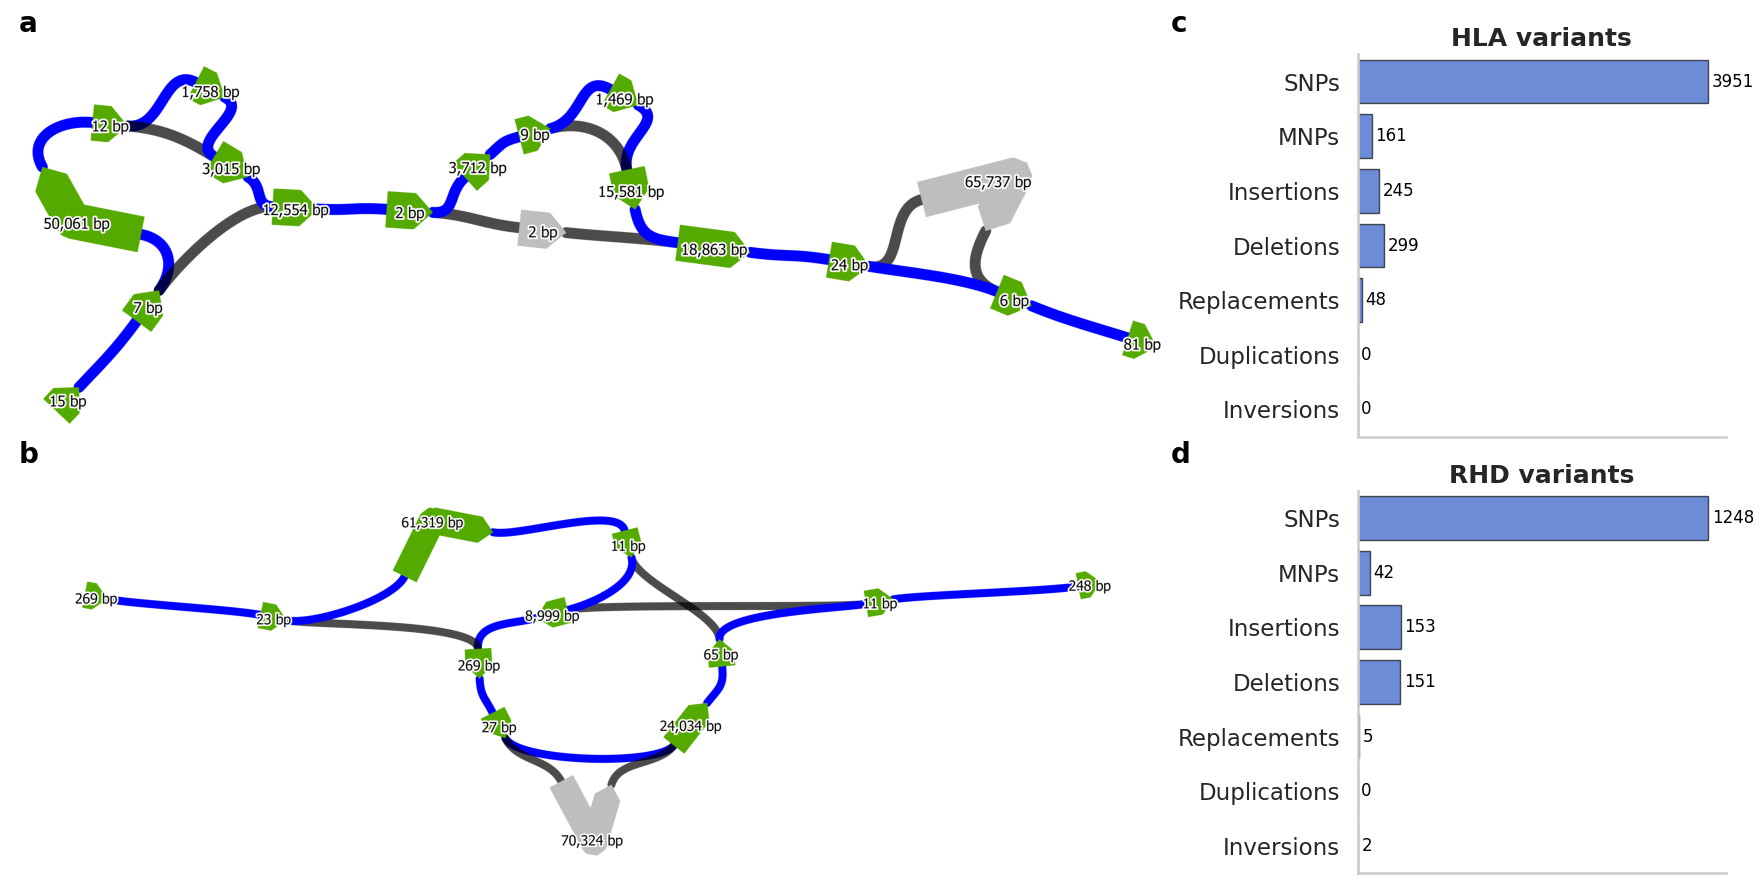

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

svg1 = svg_to_png(svg1_path, padding_ratio=0.02, dpi=600)
svg2 = svg_to_png(svg2_path, dpi=600)

# Create figure and define a flexible grid layout
fig = plt.figure(figsize=(18, 9))  # Define overall figure size
gs = gridspec.GridSpec(2, 6, width_ratios=[1, 1, 1, 1, 0.6, 0.6], height_ratios=[1, 1])  

# First three charts in the first column (one per row)
ax1 = fig.add_subplot(gs[0, 0:4])  # Row 1, Col 1
ax2 = fig.add_subplot(gs[1, 0:4])  # Row 2, Col 1

ax3 = fig.add_subplot(gs[0, 4:])  # Row 3, Col 1
ax4 = fig.add_subplot(gs[1, 4:])  # Chart 4 takes Row 1

ax1.imshow(svg1)
ax2.imshow(svg2)
# Display images
plot_region_var(ax3, 
                "HLA", 
                special_region_summary_df, 
                colors,
                title="HLA variants")
plot_region_var(ax4, 
                "RHD", 
                special_region_summary_df, 
                colors,
                title="RHD variants")

# Remove axis labels and ticks for a clean layout
for ax in [ax1, ax2]:
    ax.axis("off")

# Define label positions to match the adjusted layout
label_positions = [(0.02, 0.989),
                   (0.02, 0.51),
                   (0.66, 0.989),
                   (0.66, 0.51)]

labels = ["a", "b", "c", "d"]

# Add global labels to the whole figure
for (x, y), label in zip(label_positions, labels):
    fig.text(x, y, label, fontsize=20, fontweight="bold", va="top", ha="left", color="black")

# Adjust layout and save the final figure
plt.tight_layout()
plt.savefig(f"{assemble_dir}/assembled_figure4.pdf", bbox_inches="tight", dpi=600)
plt.savefig(f"{assemble_dir}/assembled_figure4.png", bbox_inches="tight", dpi=600)

# Show the final image
plt.show()


Supplementary figures

In [9]:
supp_dir = f"{chart_dir}/supplementary_figures_{chr_set}"
if not os.path.exists(supp_dir):
    os.makedirs(supp_dir)

S1: Large common variants summary

/tmp/ipykernel_15300/937195415.py:10: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == cat[:-1]][colname])
/tmp/ipykernel_15300/937195415.py:15: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == cat[:-1]][colname])


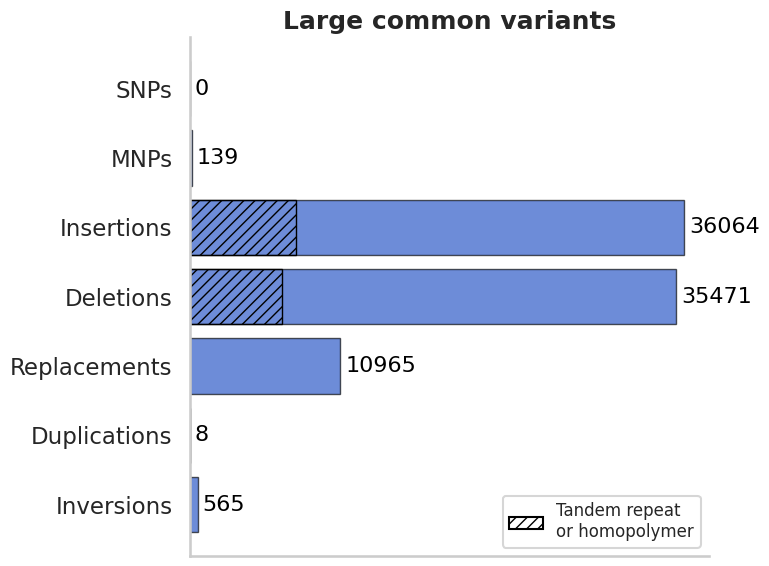

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_variant_summary_bar(ax, graph_vcf_summary_df, repeated_var_summary_df, colors, colname='Large_Common_Variants', title="Large common variants")
fig.tight_layout()
fig.savefig(f"{supp_dir}/supplementary_figure1.pdf", format='pdf')
fig.savefig(f"{supp_dir}/supplementary_figure1.png", dpi=600, bbox_inches='tight', format='png')

S2: Non-GRCh38 large variant

/tmp/ipykernel_15300/937195415.py:10: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == cat[:-1]][colname])
/tmp/ipykernel_15300/937195415.py:15: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == cat[:-1]][colname])


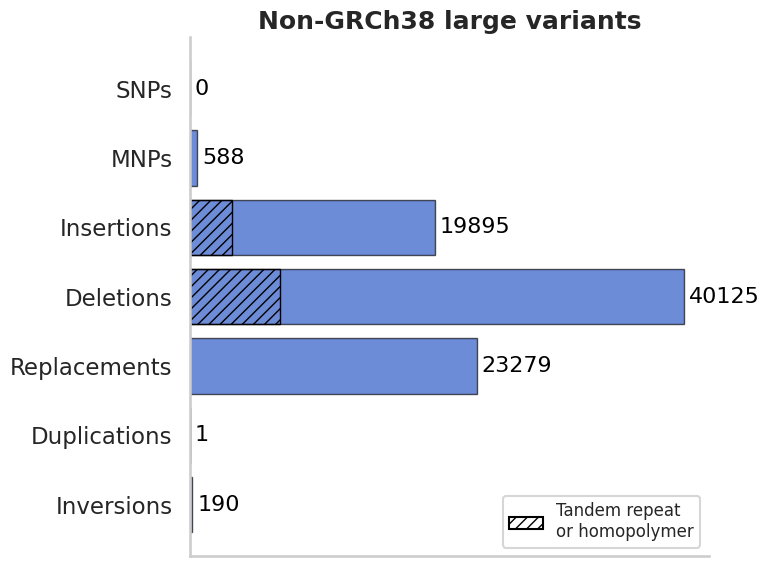

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_variant_summary_bar(ax, graph_vcf_summary_df, repeated_var_summary_df, colors, colname='Off_Linear_Large_Variants', title="Non-GRCh38 large variants")
fig.tight_layout()
fig.savefig(f"{supp_dir}/supplementary_figure2.pdf", format='pdf')
fig.savefig(f"{supp_dir}/supplementary_figure2.png", dpi=600, bbox_inches='tight', format='png')

S3: Non-GRCh38 large common variants

/tmp/ipykernel_15300/937195415.py:10: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == cat[:-1]][colname])
/tmp/ipykernel_15300/937195415.py:15: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == cat[:-1]][colname])


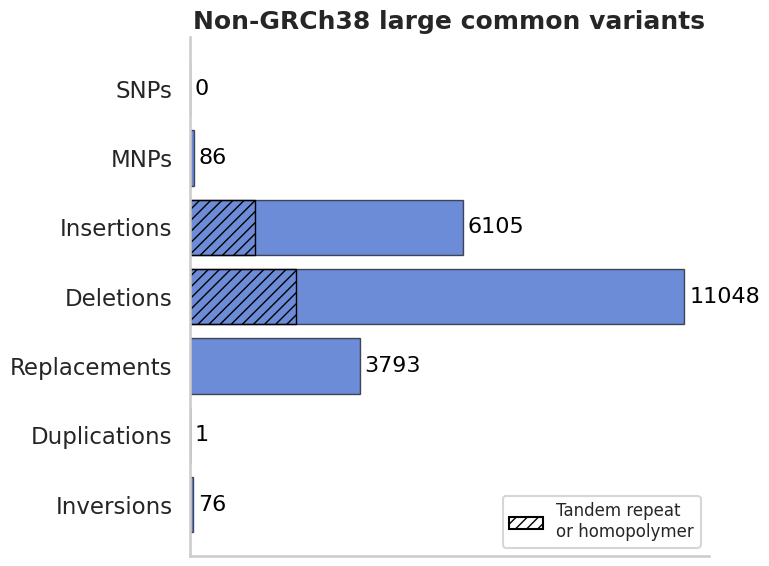

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_variant_summary_bar(ax, graph_vcf_summary_df, repeated_var_summary_df, colors, colname='Off_Linear_Large_Common_Variants', title="Non-GRCh38 large common variants")
fig.tight_layout()
fig.savefig(f"{supp_dir}/supplementary_figure3.pdf", format='pdf')
fig.savefig(f"{supp_dir}/supplementary_figure3.png", dpi=600, bbox_inches='tight', format='png')

S4: Motif length histogram

In [34]:
motif_len_list = []

for i in tqdm(chr_list):
    graph_vcf_path = f"{graph_vcf_dir}/graph_chr{i}_no_terminus.vcf"
    for row in read_vcf_line_by_line(graph_vcf_path):
        info = row['INFO']
        info_dict = {attr.split('=')[0]: attr.split('=')[1] for attr in info.split(';') if '=' in attr}
        motif = info_dict['TR_MOTIF']
        motif_len = 0 if motif == '.' else len(motif)

        motif_len_list.append(motif_len)

  0%|          | 0/22 [00:00<?, ?it/s]

100%|██████████| 22/22 [08:12<00:00, 22.37s/it]


In [35]:
motif_len_csv = pd.DataFrame({'Motif length': motif_len_list})
motif_len_csv.to_csv(f"{data_vis_dir}/motif_len_all_chr_{chr_set}.csv")

In [36]:
# Example data
motif_len_csv = pd.read_csv(f"{data_vis_dir}/motif_len_all_chr_{chr_set}.csv")
motif_len_list = motif_len_csv['Motif length'].to_list()
data = np.array(motif_len_list)  # Generate some data between 0 and 60

# Define custom bins
bins = [1, 2, 3, 6, 11, 20] + [float('inf')]
bin_labels = ["1", "2", "3-5", "6-10", "11-19", "20+"]

# Compute histogram
counts, bin_edges = np.histogram(data, bins=bins)

motif_len_distribution_df = pd.DataFrame({
    "Ranges": bin_labels,
    "Counts": counts.tolist()
})

In [37]:
motif_len_distribution_df.to_csv(f"{data_vis_dir}/motif_len_data_{chr_set}.csv", index=False)
motif_len_distribution_df

Ranges   Counts
0      1  3756994
1      2  1014195
2    3-5   622723
3   6-10    79236
4  11-19    38426
5    20+    76481

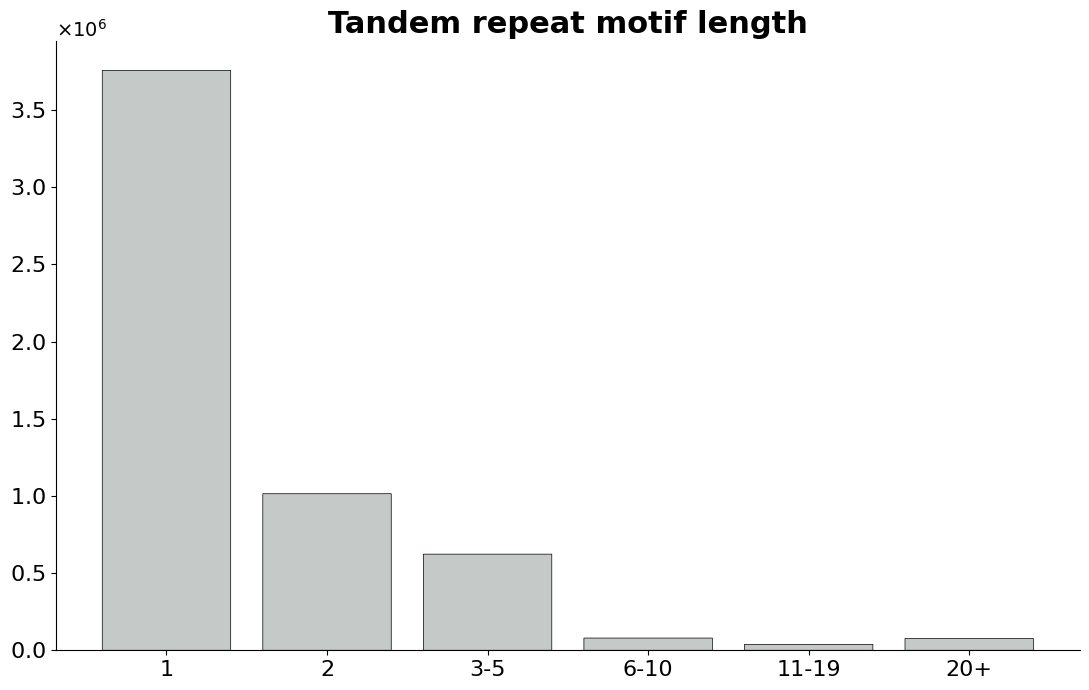

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyBboxPatch
from matplotlib.ticker import ScalarFormatter, FuncFormatter

data = pd.read_csv(f"{data_vis_dir}/motif_len_data_{chr_set}.csv")

# Compute histogram
counts, bin_labels = data['Counts'].to_numpy(), data['Ranges'].to_list()

# Create bar positions
bar_positions = np.arange(len(counts))

# Create figure
fig, ax = plt.subplots(figsize=(11, 7))

# Plot histogram bars (initially hidden)
bars = plt.bar(bar_positions, counts, edgecolor="black", alpha=0, color="none")  # Hide original bars

# Replace each bar with a rounded rectangle
for bar, count in zip(bars, counts):
    x, y = bar.get_x(), bar.get_y()
    width, height = bar.get_width(), bar.get_height()

    # Create rounded bar
    rounded_bar = FancyBboxPatch(
        (x, y), width, height, 
        boxstyle="round,pad=0",  # Controls corner roundness
        facecolor="#C5C9C7", edgecolor="black", linewidth=0.5, alpha=1
    )
    ax.add_patch(rounded_bar)

# Add custom x-axis labels
plt.xticks(bar_positions, bin_labels, fontsize=16)
plt.yticks(fontsize=16)
# plt.ylim(top=800000)

# Add titles and labels
plt.title("Tandem repeat motif length", fontsize=22, weight='bold')
# plt.xlabel("Number of alternative alleles", fontsize=16)
# plt.ylabel("Frequency", fontsize=14)

ax = plt.gca()  # Get the current axes
ax.set_yticklabels([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)

# Customize the x-axis to use scientific notation
gca = plt.gca()

def scientific_notation_flexible(value, pos):
    if value == 0:
        return "0"
    exponent = int(np.floor(np.log10(abs(value))))
    base = value / 10**exponent
    return f"{base:.1f}e{exponent}"

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
y_values = counts
max_val = max(y_values)
order = int(math.floor(math.log10(max_val)))
ax.ticklabel_format(style='sci', axis='y', scilimits=(order,order))
ax.yaxis.offsetText.set_fontsize(14)

# y_bias = 0.01 * max(counts)

# # Annotate bar counts
# for i, count in enumerate(counts):
#     plt.text(i, count + y_bias, str(count), ha="center", fontsize=15)

# Show plot
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig(f"{supp_dir}/supplementary_figure4.pdf", format='pdf')
plt.savefig(f"{supp_dir}/supplementary_figure4.png", dpi=600, bbox_inches='tight', format='png')

plt.show()

S5: Vcfwave example inconsistant with graph

S6: Example both rawvcf and vcfwave missed a SNP

S7: SNPs comparison with raw vcf

S8: Proportion of multiallelic superbubbles

In [16]:
def save_subplot(plot_function, df, filename, w = 10, h = 8, title=None):
    fig, axs = plt.subplots(1, 1, figsize=(w, h))
    # Use your custom plot function on each subplot
    plot_function(axs, df, title=title)

    fig.tight_layout()

    fig.savefig(f"{filename}.pdf", format='pdf')
    fig.savefig(f"{filename}.svg", format='svg')
    fig.savefig(f"{filename}.png", bbox_inches="tight", dpi=600)

In [ ]:
save_subplot(plot_superbubble_summary_hatched, 
             superbubble_summary_df, 
             f"{chart_dir}/subplots_{chr_set}/figure3_supp",
             w = 5, h = 5)

S9: Variant summary of chromosome X and SNPs comparison with VCF wave

S10: Variant summary of chromosome Y and SNPs comparison with VCF wave

S11: Variants comparison between GRCh38 and CHM13

In [1]:
import os
os.chdir('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/graph_var')

from graph_var.utils import load_graph_from_pkl, merge_dicts, log_action
from graph_var.graph import PangenomeGraph
from graph_var.evaluating_functions import *
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patches as mpatches
import math

version = 'v2'

graph_vcf_dir_grch38 = f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_{version}"
graph_vcf_dir_chm13 = f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_{version}_chm13"

var_summary_dir_grch38 = f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Stats_chr_{version}"
var_summary_dir_chm13 = f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Stats_chr_{version}_chm13"

data_vis_dir_grch38 = f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization_{version}"
data_vis_dir_chm13 = f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization_{version}_chm13"

chart_dir = f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts_{version}"
region_dir = f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Region_files"

#num_chr = len(chr_list)

fig1size = (14, 12)

title_fs = 14
barnum_fs = 12
legend_fs = 10
xtick_fs = 12
ytick_fs = 12
xlabel_fs = 14
ylabel_fs = 14
yoffset_fs = 14

panel_fs = 20

In [35]:
def variant_edges_summary_from_dict(var_list: list, var_dict: dict):
    summary_dict = dict()
    for edge in sorted(list(var_list)):
        summary_dict[var_dict[edge]] = summary_dict.get(var_dict[edge], 0) + 1
    summary_dict['Total'] = len(var_list)
    return summary_dict

def prepare_dataframe_dict(var_dict):
    return pd.DataFrame({
        "Variant Type": ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement', 'Inversion', 'Duplication', 'Total'],
        "Count": [
                  var_dict.get('SNP', 0),
                  var_dict.get('MNP', 0),
                  var_dict.get('INS', 0),
                  var_dict.get('DEL', 0),
                  var_dict.get('REP', 0),
                  var_dict.get('INV', 0),
                  var_dict.get('DUP', 0),
                  var_dict.get('Total', 0),
        ]
    })

def comprehensive_summary(graph_vcf_input: Union[str, pd.DataFrame], 
                          chrom_set: list, 
                          compressed: bool=False,
                          tandem_repeat: bool=False,
                          pos_range: Dict[str, list[tuple]]=None):
    variant_sets = defaultdict(set)
    var_dict = dict()

    if isinstance(graph_vcf_input, str):
        row_iter = read_vcf_line_by_line(graph_vcf_input, compressed=compressed)
    elif isinstance(graph_vcf_input, pd.DataFrame):
        row_iter = graph_vcf_input.to_dict(orient="records")
    else:
        raise ValueError("Input must be either a path to VCF or a pandas DataFrame.")

    for row in row_iter:
        chr = row['#CHROM'][3:]
        if chr not in chrom_set:
            continue
        edge = row['ID']
        pos = int(row['POS'])
        if pos_range is not None:
            assert len(pos_range[f"chr{chr}"]) > 0
            if isinstance(pos_range[f"chr{chr}"], tuple):
                if not (pos >= pos_range[f"chr{chr}"][0] and pos <= pos_range[f"chr{chr}"][1]):
                    continue
            elif isinstance(pos_range[f"chr{chr}"], list):
                if not any([(pos >= start and pos <= end) for start, end in pos_range[f"chr{chr}"]]):
                    continue
        info_dict = {k: v for k, v in (field.split('=') for field in row['INFO'].split(';') if '=' in field)}
        var_type = info_dict['VT']
        nearly_identical = int(info_dict['NIA'])
        allele_count = int(info_dict['AC']) if var_type == 'INV' else min(int(info_dict['RC']), int(info_dict['AC']))
        ref_allele = row['REF'] if row['REF'] != '.' else info_dict['NR']
        alt_allele = row['ALT']
        allele_length = len(ref_allele) + len(alt_allele)
        on_linear = (int(info_dict['DR'].split(',')[1]) == 0)

        is_repeat = info_dict['TR_MOTIF'] != '.'

        if tandem_repeat and not is_repeat:
            continue

        var_dict[edge] = var_type
        variant_sets['All'].add(edge)
        variant_sets['Linear' if on_linear else 'Off_Linear'].add(edge)
        variant_sets['Small' if allele_length < 50 or nearly_identical else 'Large'].add(edge)
        variant_sets['Common' if allele_count >= 5 else 'Uncommon'].add(edge)

    # Generate combinations
    for a in ['Linear', 'Off_Linear']:
        for b in ['Small', 'Large']:
            variant_sets[f'{a}_{b}'] = variant_sets[a].intersection(variant_sets[b])
        for c in ['Common', 'Uncommon']:
            variant_sets[f'{a}_{c}'] = variant_sets[a].intersection(variant_sets[c])
    for b in ['Small', 'Large']:
        for c in ['Common', 'Uncommon']:
            variant_sets[f'{b}_{c}'] = variant_sets[b].intersection(variant_sets[c])
            for a in ['Linear', 'Off_Linear']:
                variant_sets[f'{a}_{b}_{c}'] = variant_sets[a].intersection(variant_sets[f'{b}_{c}'])

    # Construct DataFrames
    all_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(variant_sets['All'], var_dict))
    summary_dict = {'Variant Type': all_var_df['Variant Type']}
    for key, variant_set in variant_sets.items():
        df = prepare_dataframe_dict(variant_edges_summary_from_dict(variant_set, var_dict))
        summary_dict[key+"_Variants"] = df['Count']

    return pd.DataFrame(summary_dict, columns=[
        "CHROM",
        "Variant Type",
        "All_Variants",
        "Linear_Variants",
        "Off_Linear_Variants",
        "Small_Variants",
        "Large_Variants",
        "Common_Variants",
        "Uncommon_Variants",
        "Linear_Small_Variants",
        "Linear_Large_Variants",
        "Off_Linear_Small_Variants",
        "Off_Linear_Large_Variants",
        "Linear_Common_Variants",
        "Linear_Uncommon_Variants",
        "Off_Linear_Common_Variants",
        "Off_Linear_Uncommon_Variants",
        "Small_Common_Variants",
        "Small_Uncommon_Variants",
        "Large_Common_Variants",
        "Large_Uncommon_Variants",
        "Linear_Small_Common_Variants",
        "Linear_Large_Common_Variants",
        "Linear_Small_Uncommon_Variants",
        "Linear_Large_Uncommon_Variants",
        "Off_Linear_Small_Common_Variants",
        "Off_Linear_Large_Common_Variants",
        "Off_Linear_Small_Uncommon_Variants",
        "Off_Linear_Large_Uncommon_Variants"
        ])

Variants in acrocentric arm

Variants in centromeres, subtelomeres and acrocentric arms

In [36]:
def get_pos_dict_from_bed(bed_path):
    pos_dict = defaultdict(list)
    with open(bed_path, 'r') as bed:
        for line in bed:
            parts = line.strip().split('\t')
            chr_name = parts[0]
            start = int(parts[1])
            end = int(parts[2])
            pos_dict[chr_name].append((start, end))
    return pos_dict

In [37]:
grch38_bed_dict = get_pos_dict_from_bed(f"{region_dir}/hs38.excl.bed")
chm13_bed_dict = get_pos_dict_from_bed(f"{region_dir}/chm13v2.excl.bed")

In [38]:
grch38_chr_set = list(map(lambda x: str(x), range(1,23)))

graph_vcf_path = f"{graph_vcf_dir_grch38}/graph_all_chr_no_terminus.vcf.gz"
comp_var_summary_df = comprehensive_summary(graph_vcf_path, grch38_chr_set, pos_range=grch38_bed_dict, compressed=True)
comp_var_summary_df.to_csv(f"{var_summary_dir_grch38}/comprehensive_variant_summary_for_grch38_autosome_in_excl_complex_region.csv", index=False)


In [39]:
chm13_chr_set = list(map(lambda x: str(x), range(1,23)))

graph_vcf_path = f"{graph_vcf_dir_chm13}/graph_all_chr_no_terminus.vcf.gz"
comp_var_summary_df = comprehensive_summary(graph_vcf_path, chm13_chr_set, pos_range=chm13_bed_dict, compressed=True)
comp_var_summary_df.to_csv(f"{var_summary_dir_chm13}/comprehensive_variant_summary_for_chm13_autosome_in_excl_complex_region.csv", index=False)

In [6]:
grch38_chr_set = list(map(lambda x: str(x), range(1,23)))

graph_vcf_path = f"{graph_vcf_dir_grch38}/graph_all_chr_no_terminus.vcf.gz"
comp_var_summary_df = comprehensive_summary(graph_vcf_path, grch38_chr_set, compressed=True)
comp_var_summary_df.to_csv(f"{var_summary_dir_grch38}/comprehensive_variant_summary_for_grch38_autosome.csv", index=False)


In [7]:
chm13_chr_set = list(map(lambda x: str(x), range(1,23)))

graph_vcf_path = f"{graph_vcf_dir_chm13}/graph_all_chr_no_terminus.vcf.gz"
comp_var_summary_df = comprehensive_summary(graph_vcf_path, chm13_chr_set, compressed=True)
comp_var_summary_df.to_csv(f"{var_summary_dir_chm13}/comprehensive_variant_summary_for_chm13_autosome.csv", index=False)


Load data

In [44]:
import pandas as pd

graph_vcf_summary_df_grch38_excl = pd.read_csv(f"{var_summary_dir_grch38}/comprehensive_variant_summary_for_grch38_autosome_in_excl_complex_region.csv")
graph_vcf_summary_df_chm13_excl = pd.read_csv(f"{var_summary_dir_chm13}/comprehensive_variant_summary_for_chm13_autosome_in_excl_complex_region.csv")

graph_vcf_summary_df_grch38 = pd.read_csv(f"{var_summary_dir_grch38}/comprehensive_variant_summary_for_grch38_autosome.csv")
graph_vcf_summary_df_chm13 = pd.read_csv(f"{var_summary_dir_chm13}/comprehensive_variant_summary_for_chm13_autosome.csv")


In [11]:
def plot_variant_comparison_bar(ax, 
                             graph_vcf_summary_df_grch38, 
                             graph_vcf_summary_df_chm13, 
                             colname, 
                             title="No title",
                             shade=False,
                             graph_vcf_summary_df_grch38_shade=None,
                             graph_vcf_summary_df_chm13_shade=None,
                             shade_title='Unspecified'):
    categories = ['SNPs', 'MNPs', 'Insertions', 'Deletions', 'Replacements', 'Duplications', 'Inversions']

    values_1 = [
        int(graph_vcf_summary_df_grch38[graph_vcf_summary_df_grch38['Variant Type'] == cat[:-1]][colname]) 
        for cat in categories
    ]

    values_2 = [
        int(graph_vcf_summary_df_chm13[graph_vcf_summary_df_chm13['Variant Type'] == cat[:-1]][colname]) 
        for cat in categories
    ]

    if shade:
        if graph_vcf_summary_df_grch38_shade is not None:
            shaded_values_1 = [
                            int(graph_vcf_summary_df_grch38_shade[graph_vcf_summary_df_grch38_shade['Variant Type'] == cat[:-1]][colname]) 
                            for cat in categories
                        ]
        if graph_vcf_summary_df_chm13_shade is not None:
            shaded_values_2 = [
                            int(graph_vcf_summary_df_chm13_shade[graph_vcf_summary_df_chm13_shade['Variant Type'] == cat[:-1]][colname]) 
                            for cat in categories
                        ]

    # Prepare long-format DataFrame for grouped bars
    data = pd.DataFrame({
        'Category': categories * 2,
        'Count': values_1 + values_2,
        'Group': ['GRCh38'] * len(categories) + ['CHM13'] * len(categories)
    })

    # Draw grouped horizontal bars using seaborn
    sns.set_theme(style="whitegrid", context="talk")
    bars = sns.barplot(y='Category', x='Count', hue='Group', data=data, ax=ax, 
                       palette=["#4C72B0", "#D62728"], orient='h', dodge=True)

    # Annotate bars with values
    max_count = data['Count'].max()
    offset = 0.01 * max_count

    for i, bar in enumerate(ax.patches):
        width = bar.get_width()

        if i in {14, 15}:
            continue

        y = bar.get_y() + bar.get_height() / 2
        ax.text(width + offset, y, f"{int(width)}", va='center', fontsize=barnum_fs)

        if shade:
            category_index = i % 7
            is_grch38 = i // 7 == 0
            is_chm13 = i // 7 == 1
            if graph_vcf_summary_df_grch38_shade is not None:
                shaded_value_1 = shaded_values_1[category_index]
            if graph_vcf_summary_df_chm13_shade is not None:
                shaded_value_2 = shaded_values_2[category_index]

            if graph_vcf_summary_df_grch38_shade is not None:
                if is_grch38 and shaded_value_1 > 0:
                    ax.barh(
                        y=bar.get_y() + bar.get_height() / 2,
                        width=shaded_value_1,
                        height=bar.get_height()*0.8,
                        left=bar.get_x(),
                        color='none',
                        edgecolor='black',
                        hatch='///',
                        linewidth=1
                    )
            
            if graph_vcf_summary_df_chm13_shade is not None:
                if is_chm13 and shaded_value_2 > 0:
                    ax.barh(
                        y=bar.get_y() + bar.get_height() / 2,
                        width=shaded_value_2,
                        height=bar.get_height()*0.8,
                        left=bar.get_x(),
                        color='none',
                        edgecolor='black',
                        hatch='///',
                        linewidth=1
                    )

    # Axis and grid styling
    ax.set_title(title, fontsize=title_fs, weight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([])
    #ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    #ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    ax.grid(False)
    sns.despine(ax=ax, left=False, bottom=False)

    if shade:
        # Get existing handles and labels from seaborn legend
        handles, labels = ax.get_legend_handles_labels()

        # Create a custom legend patch for the shaded area
        hatch_patch = mpatches.Patch(
            facecolor='none',
            edgecolor='black',
            hatch='///',
            label=shade_title
        )

        # Combine and update the legend
        handles.append(hatch_patch)
        ax.legend(handles=handles, fontsize=legend_fs, loc='lower right')
    else:
        ax.legend(fontsize=legend_fs, loc='lower right')

In [12]:
def save_subplot(plot_function, filename, w = 10, h = 8, *df):
    fig, axs = plt.subplots(1, 1, figsize=(w, h))
    # Use your custom plot function on each subplot
    plot_function(axs, *df)

    fig.tight_layout()

    fig.savefig(f"{filename}.pdf", format='pdf')
    fig.savefig(f"{filename}.svg", format='svg')
    fig.savefig(f"{filename}.png", bbox_inches="tight", dpi=600)

/tmp/ipykernel_21859/2794351849.py:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df_grch38[graph_vcf_summary_df_grch38['Variant Type'] == cat[:-1]][colname])
/tmp/ipykernel_21859/2794351849.py:18: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df_chm13[graph_vcf_summary_df_chm13['Variant Type'] == cat[:-1]][colname])
/tmp/ipykernel_21859/2794351849.py:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df_grch38[graph_vcf_summary_df_grch38['Variant Type'] == cat[:-1]][colname])
/tmp/ipykernel_21859/2794351849.py:18: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc

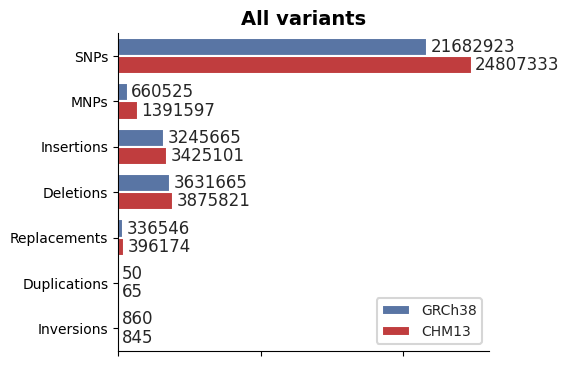

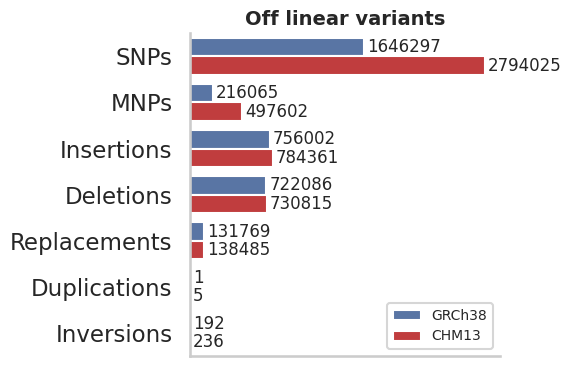

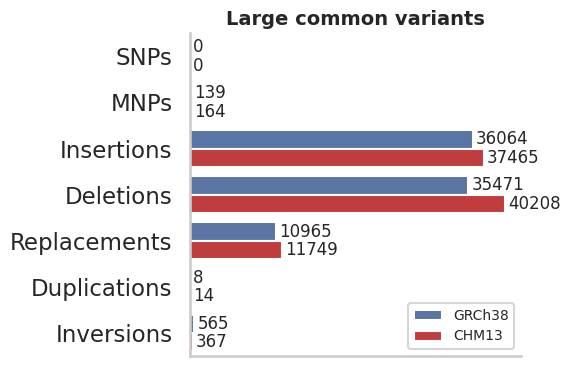

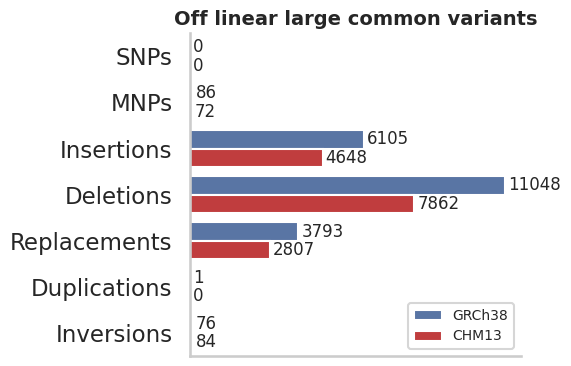

In [30]:
save_subplot(plot_variant_comparison_bar,
             f"{chart_dir}/supplementary_figures_{chr_set}/supplementary_figure11_panela",
             6, 4,
             graph_vcf_summary_df_grch38, 
             graph_vcf_summary_df_chm13, 
             "All_Variants", 
             "All variants")
save_subplot(plot_variant_comparison_bar,
             f"{chart_dir}/supplementary_figures_{chr_set}/supplementary_figure11_panelb",
             6, 4,
             graph_vcf_summary_df_grch38, 
             graph_vcf_summary_df_chm13, 
             "Off_Linear_Variants", 
             "Off linear variants")
save_subplot(plot_variant_comparison_bar,
             f"{chart_dir}/supplementary_figures_{chr_set}/supplementary_figure11_panelc",
             6, 4,
             graph_vcf_summary_df_grch38, 
             graph_vcf_summary_df_chm13, 
             "Large_Common_Variants", 
             "Large common variants")
save_subplot(plot_variant_comparison_bar,
             f"{chart_dir}/supplementary_figures_{chr_set}/supplementary_figure11_paneld",
             6, 4,
             graph_vcf_summary_df_grch38, 
             graph_vcf_summary_df_chm13, 
             "Off_Linear_Large_Common_Variants", 
             "Off linear large common variants")

/tmp/ipykernel_2693/946141729.py:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df_grch38[graph_vcf_summary_df_grch38['Variant Type'] == cat[:-1]][colname])
/tmp/ipykernel_2693/946141729.py:18: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df_chm13[graph_vcf_summary_df_chm13['Variant Type'] == cat[:-1]][colname])
/tmp/ipykernel_2693/946141729.py:25: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df_grch38_shade[graph_vcf_summary_df_grch38_shade['Variant Type'] == cat[:-1]][colname])
/tmp/ipykernel_2693/946141729.py:30: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.

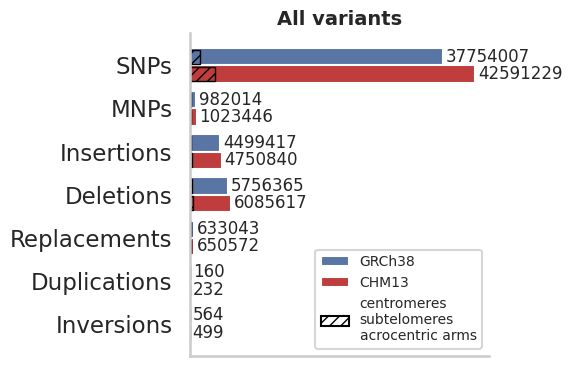

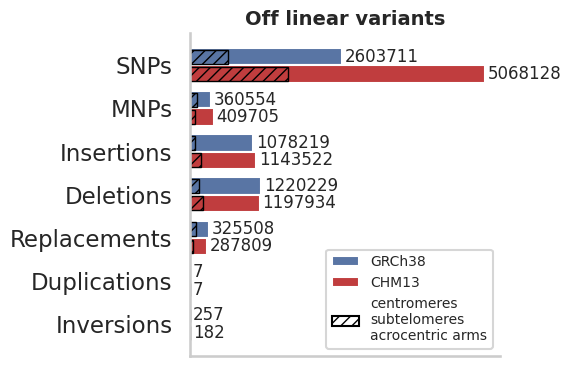

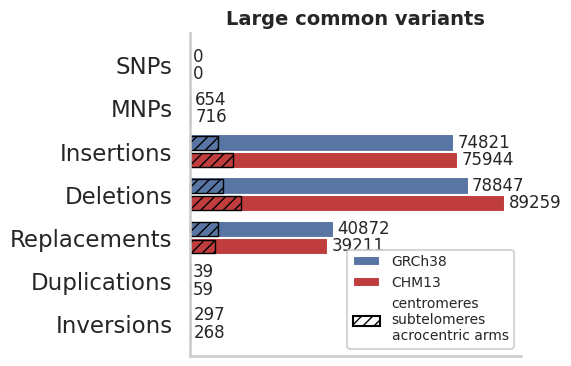

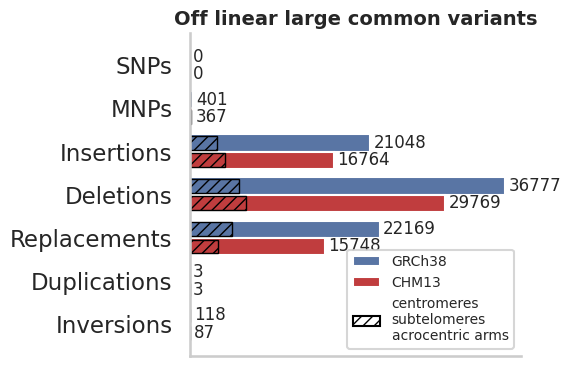

In [46]:
save_subplot(plot_variant_comparison_bar,
             f"{chart_dir}/supplementary_figures_autosome/supplementary_figure11_9",
             6, 4,
             graph_vcf_summary_df_grch38, 
             graph_vcf_summary_df_chm13, 
             "All_Variants", 
             "All variants",
             True,
             graph_vcf_summary_df_grch38_excl,
             graph_vcf_summary_df_chm13_excl,
             "centromeres\nsubtelomeres\nacrocentric arms")
save_subplot(plot_variant_comparison_bar,
             f"{chart_dir}/supplementary_figures_autosome/supplementary_figure11_10",
             6, 4,
             graph_vcf_summary_df_grch38, 
             graph_vcf_summary_df_chm13, 
             "Off_Linear_Variants", 
             "Off linear variants",
             True,
             graph_vcf_summary_df_grch38_excl,
             graph_vcf_summary_df_chm13_excl,
             "centromeres\nsubtelomeres\nacrocentric arms")
save_subplot(plot_variant_comparison_bar,
             f"{chart_dir}/supplementary_figures_autosome/supplementary_figure11_11",
             6, 4,
             graph_vcf_summary_df_grch38, 
             graph_vcf_summary_df_chm13, 
             "Large_Common_Variants", 
             "Large common variants",
             True,
             graph_vcf_summary_df_grch38_excl,
             graph_vcf_summary_df_chm13_excl,
             "centromeres\nsubtelomeres\nacrocentric arms")
save_subplot(plot_variant_comparison_bar,
             f"{chart_dir}/supplementary_figures_autosome/supplementary_figure11_12",
             6, 4,
             graph_vcf_summary_df_grch38, 
             graph_vcf_summary_df_chm13, 
             "Off_Linear_Large_Common_Variants", 
             "Off linear large common variants",
             True,
             graph_vcf_summary_df_grch38_excl,
             graph_vcf_summary_df_chm13_excl,
             "centromeres\nsubtelomeres\nacrocentric arms")